In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4272856, 828)
(4272856, 8)
validation
(622688, 828)
(622688, 8)
test
(494648, 828)
(494648, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/428 [..............................] - ETA: 9:15 - loss: 2.2056 - STD: 0.0616 - MAE: 0.2177

  5/428 [..............................] - ETA: 7s - loss: 2.0993 - STD: 0.0441 - MAE: 0.2170  

  9/428 [..............................] - ETA: 6s - loss: 2.0863 - STD: 0.0440 - MAE: 0.2166

 13/428 [..............................] - ETA: 6s - loss: 2.0758 - STD: 0.0402 - MAE: 0.2167

 17/428 [>.............................] - ETA: 6s - loss: 2.0701 - STD: 0.0382 - MAE: 0.2167

 21/428 [>.............................] - ETA: 6s - loss: 2.0631 - STD: 0.0377 - MAE: 0.2165

 25/428 [>.............................] - ETA: 6s - loss: 2.0556 - STD: 0.0368 - MAE: 0.2163

 29/428 [=>............................] - ETA: 6s - loss: 2.0449 - STD: 0.0376 - MAE: 0.2159

 33/428 [=>............................] - ETA: 6s - loss: 2.0318 - STD: 0.0398 - MAE: 0.2153

 37/428 [=>............................] - ETA: 6s - loss: 2.0184 - STD: 0.0427 - MAE: 0.2145

 41/428 [=>............................] - ETA: 6s - loss: 2.0043 - STD: 0.0458 - MAE: 0.2138

 45/428 [==>...........................] - ETA: 5s - loss: 1.9904 - STD: 0.0484 - MAE: 0.2130

 49/428 [==>...........................] - ETA: 5s - loss: 1.9765 - STD: 0.0509 - MAE: 0.2123

 53/428 [==>...........................] - ETA: 5s - loss: 1.9625 - STD: 0.0532 - MAE: 0.2116

 57/428 [==>...........................] - ETA: 5s - loss: 1.9484 - STD: 0.0557 - MAE: 0.2109

 61/428 [===>..........................] - ETA: 5s - loss: 1.9346 - STD: 0.0579 - MAE: 0.2102

 65/428 [===>..........................] - ETA: 5s - loss: 1.9206 - STD: 0.0600 - MAE: 0.2094

 69/428 [===>..........................] - ETA: 5s - loss: 1.9063 - STD: 0.0621 - MAE: 0.2087

 73/428 [====>.........................] - ETA: 5s - loss: 1.8921 - STD: 0.0643 - MAE: 0.2078

 77/428 [====>.........................] - ETA: 5s - loss: 1.8770 - STD: 0.0666 - MAE: 0.2069

 81/428 [====>.........................] - ETA: 5s - loss: 1.8615 - STD: 0.0691 - MAE: 0.2059

 85/428 [====>.........................] - ETA: 5s - loss: 1.8462 - STD: 0.0718 - MAE: 0.2048

 89/428 [=====>........................] - ETA: 5s - loss: 1.8313 - STD: 0.0745 - MAE: 0.2038

 93/428 [=====>........................] - ETA: 5s - loss: 1.8172 - STD: 0.0771 - MAE: 0.2027

 97/428 [=====>........................] - ETA: 5s - loss: 1.8036 - STD: 0.0796 - MAE: 0.2017

101/428 [======>.......................] - ETA: 5s - loss: 1.7904 - STD: 0.0820 - MAE: 0.2008

105/428 [======>.......................] - ETA: 5s - loss: 1.7777 - STD: 0.0842 - MAE: 0.1999

109/428 [======>.......................] - ETA: 4s - loss: 1.7654 - STD: 0.0864 - MAE: 0.1990

113/428 [======>.......................] - ETA: 4s - loss: 1.7539 - STD: 0.0885 - MAE: 0.1981

117/428 [=======>......................] - ETA: 4s - loss: 1.7424 - STD: 0.0905 - MAE: 0.1972

121/428 [=======>......................] - ETA: 4s - loss: 1.7315 - STD: 0.0923 - MAE: 0.1964

125/428 [=======>......................] - ETA: 4s - loss: 1.7212 - STD: 0.0942 - MAE: 0.1956

129/428 [========>.....................] - ETA: 4s - loss: 1.7115 - STD: 0.0959 - MAE: 0.1949

133/428 [========>.....................] - ETA: 4s - loss: 1.7021 - STD: 0.0976 - MAE: 0.1942

137/428 [========>.....................] - ETA: 4s - loss: 1.6928 - STD: 0.0992 - MAE: 0.1935

141/428 [========>.....................] - ETA: 4s - loss: 1.6843 - STD: 0.1007 - MAE: 0.1928

145/428 [=========>....................] - ETA: 4s - loss: 1.6757 - STD: 0.1022 - MAE: 0.1921

149/428 [=========>....................] - ETA: 4s - loss: 1.6677 - STD: 0.1036 - MAE: 0.1915

153/428 [=========>....................] - ETA: 4s - loss: 1.6600 - STD: 0.1050 - MAE: 0.1909

157/428 [==========>...................] - ETA: 4s - loss: 1.6524 - STD: 0.1063 - MAE: 0.1903

161/428 [==========>...................] - ETA: 4s - loss: 1.6450 - STD: 0.1075 - MAE: 0.1897

165/428 [==========>...................] - ETA: 4s - loss: 1.6382 - STD: 0.1088 - MAE: 0.1892

169/428 [==========>...................] - ETA: 4s - loss: 1.6315 - STD: 0.1099 - MAE: 0.1886

173/428 [===========>..................] - ETA: 3s - loss: 1.6251 - STD: 0.1111 - MAE: 0.1881

177/428 [===========>..................] - ETA: 3s - loss: 1.6190 - STD: 0.1122 - MAE: 0.1876

181/428 [===========>..................] - ETA: 3s - loss: 1.6128 - STD: 0.1132 - MAE: 0.1871

185/428 [===========>..................] - ETA: 3s - loss: 1.6069 - STD: 0.1142 - MAE: 0.1867

189/428 [============>.................] - ETA: 3s - loss: 1.6013 - STD: 0.1153 - MAE: 0.1862

193/428 [============>.................] - ETA: 3s - loss: 1.5960 - STD: 0.1162 - MAE: 0.1858

197/428 [============>.................] - ETA: 3s - loss: 1.5906 - STD: 0.1171 - MAE: 0.1853

201/428 [=============>................] - ETA: 3s - loss: 1.5855 - STD: 0.1181 - MAE: 0.1849

205/428 [=============>................] - ETA: 3s - loss: 1.5804 - STD: 0.1189 - MAE: 0.1845

209/428 [=============>................] - ETA: 3s - loss: 1.5755 - STD: 0.1198 - MAE: 0.1841

213/428 [=============>................] - ETA: 3s - loss: 1.5708 - STD: 0.1206 - MAE: 0.1837

217/428 [==============>...............] - ETA: 3s - loss: 1.5661 - STD: 0.1215 - MAE: 0.1833

221/428 [==============>...............] - ETA: 3s - loss: 1.5615 - STD: 0.1223 - MAE: 0.1829

225/428 [==============>...............] - ETA: 3s - loss: 1.5571 - STD: 0.1230 - MAE: 0.1826

229/428 [===============>..............] - ETA: 3s - loss: 1.5527 - STD: 0.1238 - MAE: 0.1822

233/428 [===============>..............] - ETA: 3s - loss: 1.5483 - STD: 0.1245 - MAE: 0.1818

237/428 [===============>..............] - ETA: 2s - loss: 1.5440 - STD: 0.1252 - MAE: 0.1815

241/428 [===============>..............] - ETA: 2s - loss: 1.5399 - STD: 0.1259 - MAE: 0.1812

245/428 [================>.............] - ETA: 2s - loss: 1.5359 - STD: 0.1266 - MAE: 0.1808

249/428 [================>.............] - ETA: 2s - loss: 1.5320 - STD: 0.1273 - MAE: 0.1805

253/428 [================>.............] - ETA: 2s - loss: 1.5282 - STD: 0.1279 - MAE: 0.1802

257/428 [=================>............] - ETA: 2s - loss: 1.5244 - STD: 0.1286 - MAE: 0.1799

261/428 [=================>............] - ETA: 2s - loss: 1.5209 - STD: 0.1292 - MAE: 0.1796

265/428 [=================>............] - ETA: 2s - loss: 1.5173 - STD: 0.1298 - MAE: 0.1793

269/428 [=================>............] - ETA: 2s - loss: 1.5137 - STD: 0.1305 - MAE: 0.1789

273/428 [==================>...........] - ETA: 2s - loss: 1.5101 - STD: 0.1311 - MAE: 0.1786

277/428 [==================>...........] - ETA: 2s - loss: 1.5067 - STD: 0.1317 - MAE: 0.1784

281/428 [==================>...........] - ETA: 2s - loss: 1.5032 - STD: 0.1322 - MAE: 0.1781

285/428 [==================>...........] - ETA: 2s - loss: 1.5000 - STD: 0.1328 - MAE: 0.1778

289/428 [===================>..........] - ETA: 2s - loss: 1.4967 - STD: 0.1333 - MAE: 0.1775

293/428 [===================>..........] - ETA: 2s - loss: 1.4935 - STD: 0.1339 - MAE: 0.1772

297/428 [===================>..........] - ETA: 2s - loss: 1.4904 - STD: 0.1344 - MAE: 0.1770

301/428 [====================>.........] - ETA: 1s - loss: 1.4873 - STD: 0.1349 - MAE: 0.1767

305/428 [====================>.........] - ETA: 1s - loss: 1.4842 - STD: 0.1354 - MAE: 0.1764

309/428 [====================>.........] - ETA: 1s - loss: 1.4815 - STD: 0.1359 - MAE: 0.1762

313/428 [====================>.........] - ETA: 1s - loss: 1.4787 - STD: 0.1364 - MAE: 0.1760

317/428 [=====================>........] - ETA: 1s - loss: 1.4758 - STD: 0.1369 - MAE: 0.1757

321/428 [=====================>........] - ETA: 1s - loss: 1.4730 - STD: 0.1373 - MAE: 0.1755

325/428 [=====================>........] - ETA: 1s - loss: 1.4702 - STD: 0.1378 - MAE: 0.1752

329/428 [======================>.......] - ETA: 1s - loss: 1.4676 - STD: 0.1383 - MAE: 0.1750

333/428 [======================>.......] - ETA: 1s - loss: 1.4649 - STD: 0.1387 - MAE: 0.1748

337/428 [======================>.......] - ETA: 1s - loss: 1.4622 - STD: 0.1391 - MAE: 0.1746

341/428 [======================>.......] - ETA: 1s - loss: 1.4595 - STD: 0.1396 - MAE: 0.1743

345/428 [=======================>......] - ETA: 1s - loss: 1.4569 - STD: 0.1400 - MAE: 0.1741

349/428 [=======================>......] - ETA: 1s - loss: 1.4544 - STD: 0.1404 - MAE: 0.1739

353/428 [=======================>......] - ETA: 1s - loss: 1.4518 - STD: 0.1408 - MAE: 0.1737

357/428 [========================>.....] - ETA: 1s - loss: 1.4493 - STD: 0.1412 - MAE: 0.1734

361/428 [========================>.....] - ETA: 1s - loss: 1.4467 - STD: 0.1416 - MAE: 0.1732

365/428 [========================>.....] - ETA: 0s - loss: 1.4444 - STD: 0.1421 - MAE: 0.1730

369/428 [========================>.....] - ETA: 0s - loss: 1.4420 - STD: 0.1424 - MAE: 0.1728

373/428 [=========================>....] - ETA: 0s - loss: 1.4396 - STD: 0.1428 - MAE: 0.1726

377/428 [=========================>....] - ETA: 0s - loss: 1.4372 - STD: 0.1432 - MAE: 0.1724

381/428 [=========================>....] - ETA: 0s - loss: 1.4349 - STD: 0.1436 - MAE: 0.1722

385/428 [=========================>....] - ETA: 0s - loss: 1.4327 - STD: 0.1440 - MAE: 0.1720

389/428 [==========================>...] - ETA: 0s - loss: 1.4305 - STD: 0.1443 - MAE: 0.1718

393/428 [==========================>...] - ETA: 0s - loss: 1.4284 - STD: 0.1447 - MAE: 0.1716

397/428 [==========================>...] - ETA: 0s - loss: 1.4266 - STD: 0.1450 - MAE: 0.1714

401/428 [===========================>..] - ETA: 0s - loss: 1.4243 - STD: 0.1454 - MAE: 0.1712

405/428 [===========================>..] - ETA: 0s - loss: 1.4222 - STD: 0.1457 - MAE: 0.1711

409/428 [===========================>..] - ETA: 0s - loss: 1.4201 - STD: 0.1461 - MAE: 0.1709

413/428 [===========================>..] - ETA: 0s - loss: 1.4184 - STD: 0.1464 - MAE: 0.1707

417/428 [============================>.] - ETA: 0s - loss: 1.4164 - STD: 0.1467 - MAE: 0.1705

421/428 [============================>.] - ETA: 0s - loss: 1.4144 - STD: 0.1471 - MAE: 0.1704

425/428 [============================>.] - ETA: 0s - loss: 1.4123 - STD: 0.1474 - MAE: 0.1702

428/428 [==============================] - 10s 20ms/step - loss: 1.4108 - STD: 0.1476 - MAE: 0.1700 - val_loss: 1.3566 - val_STD: 0.1748 - val_MAE: 0.1591


Epoch 2/10000


  1/428 [..............................] - ETA: 18s - loss: 1.1844 - STD: 0.1824 - MAE: 0.1508

  5/428 [..............................] - ETA: 6s - loss: 1.1965 - STD: 0.1816 - MAE: 0.1515 

  9/428 [..............................] - ETA: 6s - loss: 1.1944 - STD: 0.1814 - MAE: 0.1514

 13/428 [..............................] - ETA: 6s - loss: 1.1926 - STD: 0.1814 - MAE: 0.1513

 16/428 [>.............................] - ETA: 6s - loss: 1.1911 - STD: 0.1815 - MAE: 0.1511

 20/428 [>.............................] - ETA: 6s - loss: 1.1900 - STD: 0.1816 - MAE: 0.1510

 23/428 [>.............................] - ETA: 6s - loss: 1.1900 - STD: 0.1818 - MAE: 0.1510

 27/428 [>.............................] - ETA: 6s - loss: 1.1903 - STD: 0.1820 - MAE: 0.1509

 31/428 [=>............................] - ETA: 6s - loss: 1.1882 - STD: 0.1822 - MAE: 0.1507

 35/428 [=>............................] - ETA: 6s - loss: 1.1871 - STD: 0.1824 - MAE: 0.1506

 39/428 [=>............................] - ETA: 6s - loss: 1.1873 - STD: 0.1825 - MAE: 0.1506

 43/428 [==>...........................] - ETA: 6s - loss: 1.1870 - STD: 0.1827 - MAE: 0.1505

 47/428 [==>...........................] - ETA: 5s - loss: 1.1855 - STD: 0.1827 - MAE: 0.1504

 51/428 [==>...........................] - ETA: 5s - loss: 1.1836 - STD: 0.1828 - MAE: 0.1503

 55/428 [==>...........................] - ETA: 5s - loss: 1.1827 - STD: 0.1830 - MAE: 0.1501

 59/428 [===>..........................] - ETA: 5s - loss: 1.1818 - STD: 0.1832 - MAE: 0.1500

 63/428 [===>..........................] - ETA: 5s - loss: 1.1807 - STD: 0.1834 - MAE: 0.1499

 67/428 [===>..........................] - ETA: 5s - loss: 1.1801 - STD: 0.1835 - MAE: 0.1499

 71/428 [===>..........................] - ETA: 5s - loss: 1.1803 - STD: 0.1837 - MAE: 0.1498

 75/428 [====>.........................] - ETA: 5s - loss: 1.1801 - STD: 0.1838 - MAE: 0.1497

 79/428 [====>.........................] - ETA: 5s - loss: 1.1803 - STD: 0.1839 - MAE: 0.1497

 83/428 [====>.........................] - ETA: 5s - loss: 1.1800 - STD: 0.1840 - MAE: 0.1497

 87/428 [=====>........................] - ETA: 5s - loss: 1.1794 - STD: 0.1841 - MAE: 0.1496

 91/428 [=====>........................] - ETA: 5s - loss: 1.1789 - STD: 0.1842 - MAE: 0.1495

 95/428 [=====>........................] - ETA: 5s - loss: 1.1780 - STD: 0.1842 - MAE: 0.1495

 99/428 [=====>........................] - ETA: 5s - loss: 1.1773 - STD: 0.1843 - MAE: 0.1494

103/428 [======>.......................] - ETA: 5s - loss: 1.1766 - STD: 0.1844 - MAE: 0.1494

107/428 [======>.......................] - ETA: 4s - loss: 1.1759 - STD: 0.1845 - MAE: 0.1493

111/428 [======>.......................] - ETA: 4s - loss: 1.1749 - STD: 0.1846 - MAE: 0.1492

115/428 [=======>......................] - ETA: 4s - loss: 1.1745 - STD: 0.1846 - MAE: 0.1492

119/428 [=======>......................] - ETA: 4s - loss: 1.1737 - STD: 0.1847 - MAE: 0.1491

123/428 [=======>......................] - ETA: 4s - loss: 1.1727 - STD: 0.1848 - MAE: 0.1490

127/428 [=======>......................] - ETA: 4s - loss: 1.1715 - STD: 0.1849 - MAE: 0.1489

131/428 [========>.....................] - ETA: 4s - loss: 1.1709 - STD: 0.1850 - MAE: 0.1488

135/428 [========>.....................] - ETA: 4s - loss: 1.1701 - STD: 0.1852 - MAE: 0.1487

138/428 [========>.....................] - ETA: 4s - loss: 1.1696 - STD: 0.1852 - MAE: 0.1487

142/428 [========>.....................] - ETA: 4s - loss: 1.1691 - STD: 0.1853 - MAE: 0.1486

146/428 [=========>....................] - ETA: 4s - loss: 1.1687 - STD: 0.1855 - MAE: 0.1486

150/428 [=========>....................] - ETA: 4s - loss: 1.1685 - STD: 0.1856 - MAE: 0.1485

154/428 [=========>....................] - ETA: 4s - loss: 1.1679 - STD: 0.1857 - MAE: 0.1484

158/428 [==========>...................] - ETA: 4s - loss: 1.1673 - STD: 0.1858 - MAE: 0.1484

162/428 [==========>...................] - ETA: 4s - loss: 1.1665 - STD: 0.1859 - MAE: 0.1483

166/428 [==========>...................] - ETA: 4s - loss: 1.1657 - STD: 0.1859 - MAE: 0.1482

170/428 [==========>...................] - ETA: 3s - loss: 1.1649 - STD: 0.1860 - MAE: 0.1481

174/428 [===========>..................] - ETA: 3s - loss: 1.1643 - STD: 0.1861 - MAE: 0.1481

178/428 [===========>..................] - ETA: 3s - loss: 1.1636 - STD: 0.1862 - MAE: 0.1480

182/428 [===========>..................] - ETA: 3s - loss: 1.1628 - STD: 0.1863 - MAE: 0.1479

186/428 [============>.................] - ETA: 3s - loss: 1.1621 - STD: 0.1864 - MAE: 0.1479

190/428 [============>.................] - ETA: 3s - loss: 1.1615 - STD: 0.1865 - MAE: 0.1478

194/428 [============>.................] - ETA: 3s - loss: 1.1606 - STD: 0.1866 - MAE: 0.1477

198/428 [============>.................] - ETA: 3s - loss: 1.1598 - STD: 0.1867 - MAE: 0.1476

202/428 [=============>................] - ETA: 3s - loss: 1.1589 - STD: 0.1868 - MAE: 0.1475

206/428 [=============>................] - ETA: 3s - loss: 1.1584 - STD: 0.1869 - MAE: 0.1475

210/428 [=============>................] - ETA: 3s - loss: 1.1587 - STD: 0.1870 - MAE: 0.1474

214/428 [==============>...............] - ETA: 3s - loss: 1.1585 - STD: 0.1871 - MAE: 0.1474

218/428 [==============>...............] - ETA: 3s - loss: 1.1581 - STD: 0.1872 - MAE: 0.1473

222/428 [==============>...............] - ETA: 3s - loss: 1.1577 - STD: 0.1873 - MAE: 0.1473

226/428 [==============>...............] - ETA: 3s - loss: 1.1571 - STD: 0.1874 - MAE: 0.1472

230/428 [===============>..............] - ETA: 3s - loss: 1.1565 - STD: 0.1874 - MAE: 0.1472

234/428 [===============>..............] - ETA: 2s - loss: 1.1560 - STD: 0.1875 - MAE: 0.1471

238/428 [===============>..............] - ETA: 2s - loss: 1.1552 - STD: 0.1876 - MAE: 0.1471

242/428 [===============>..............] - ETA: 2s - loss: 1.1546 - STD: 0.1876 - MAE: 0.1470

246/428 [================>.............] - ETA: 2s - loss: 1.1538 - STD: 0.1877 - MAE: 0.1469

250/428 [================>.............] - ETA: 2s - loss: 1.1532 - STD: 0.1878 - MAE: 0.1469

254/428 [================>.............] - ETA: 2s - loss: 1.1525 - STD: 0.1879 - MAE: 0.1468

258/428 [=================>............] - ETA: 2s - loss: 1.1518 - STD: 0.1880 - MAE: 0.1467

262/428 [=================>............] - ETA: 2s - loss: 1.1512 - STD: 0.1881 - MAE: 0.1467

266/428 [=================>............] - ETA: 2s - loss: 1.1506 - STD: 0.1882 - MAE: 0.1466

270/428 [=================>............] - ETA: 2s - loss: 1.1499 - STD: 0.1882 - MAE: 0.1465

274/428 [==================>...........] - ETA: 2s - loss: 1.1492 - STD: 0.1883 - MAE: 0.1465

278/428 [==================>...........] - ETA: 2s - loss: 1.1485 - STD: 0.1884 - MAE: 0.1464

282/428 [==================>...........] - ETA: 2s - loss: 1.1481 - STD: 0.1885 - MAE: 0.1464

286/428 [===================>..........] - ETA: 2s - loss: 1.1477 - STD: 0.1886 - MAE: 0.1463

290/428 [===================>..........] - ETA: 2s - loss: 1.1474 - STD: 0.1887 - MAE: 0.1463

294/428 [===================>..........] - ETA: 2s - loss: 1.1471 - STD: 0.1887 - MAE: 0.1462

298/428 [===================>..........] - ETA: 2s - loss: 1.1466 - STD: 0.1888 - MAE: 0.1462

302/428 [====================>.........] - ETA: 1s - loss: 1.1460 - STD: 0.1889 - MAE: 0.1461

306/428 [====================>.........] - ETA: 1s - loss: 1.1454 - STD: 0.1890 - MAE: 0.1460

310/428 [====================>.........] - ETA: 1s - loss: 1.1448 - STD: 0.1890 - MAE: 0.1460

314/428 [=====================>........] - ETA: 1s - loss: 1.1441 - STD: 0.1891 - MAE: 0.1459

318/428 [=====================>........] - ETA: 1s - loss: 1.1436 - STD: 0.1892 - MAE: 0.1459

322/428 [=====================>........] - ETA: 1s - loss: 1.1429 - STD: 0.1892 - MAE: 0.1458

326/428 [=====================>........] - ETA: 1s - loss: 1.1423 - STD: 0.1893 - MAE: 0.1458

330/428 [======================>.......] - ETA: 1s - loss: 1.1418 - STD: 0.1894 - MAE: 0.1457

334/428 [======================>.......] - ETA: 1s - loss: 1.1413 - STD: 0.1895 - MAE: 0.1456

338/428 [======================>.......] - ETA: 1s - loss: 1.1406 - STD: 0.1896 - MAE: 0.1456

342/428 [======================>.......] - ETA: 1s - loss: 1.1400 - STD: 0.1896 - MAE: 0.1455

346/428 [=======================>......] - ETA: 1s - loss: 1.1395 - STD: 0.1897 - MAE: 0.1455

350/428 [=======================>......] - ETA: 1s - loss: 1.1390 - STD: 0.1898 - MAE: 0.1454

354/428 [=======================>......] - ETA: 1s - loss: 1.1388 - STD: 0.1899 - MAE: 0.1454

358/428 [========================>.....] - ETA: 1s - loss: 1.1385 - STD: 0.1900 - MAE: 0.1453

362/428 [========================>.....] - ETA: 1s - loss: 1.1381 - STD: 0.1900 - MAE: 0.1453

366/428 [========================>.....] - ETA: 0s - loss: 1.1376 - STD: 0.1901 - MAE: 0.1452

370/428 [========================>.....] - ETA: 0s - loss: 1.1370 - STD: 0.1902 - MAE: 0.1452

374/428 [=========================>....] - ETA: 0s - loss: 1.1365 - STD: 0.1902 - MAE: 0.1451

378/428 [=========================>....] - ETA: 0s - loss: 1.1360 - STD: 0.1903 - MAE: 0.1451

382/428 [=========================>....] - ETA: 0s - loss: 1.1354 - STD: 0.1904 - MAE: 0.1450

386/428 [==========================>...] - ETA: 0s - loss: 1.1348 - STD: 0.1904 - MAE: 0.1449

390/428 [==========================>...] - ETA: 0s - loss: 1.1341 - STD: 0.1905 - MAE: 0.1449

394/428 [==========================>...] - ETA: 0s - loss: 1.1335 - STD: 0.1906 - MAE: 0.1448

398/428 [==========================>...] - ETA: 0s - loss: 1.1329 - STD: 0.1907 - MAE: 0.1448

402/428 [===========================>..] - ETA: 0s - loss: 1.1324 - STD: 0.1907 - MAE: 0.1447

406/428 [===========================>..] - ETA: 0s - loss: 1.1318 - STD: 0.1908 - MAE: 0.1446

410/428 [===========================>..] - ETA: 0s - loss: 1.1313 - STD: 0.1909 - MAE: 0.1446

414/428 [============================>.] - ETA: 0s - loss: 1.1307 - STD: 0.1910 - MAE: 0.1445

418/428 [============================>.] - ETA: 0s - loss: 1.1303 - STD: 0.1910 - MAE: 0.1445

422/428 [============================>.] - ETA: 0s - loss: 1.1297 - STD: 0.1911 - MAE: 0.1444

426/428 [============================>.] - ETA: 0s - loss: 1.1293 - STD: 0.1912 - MAE: 0.1444

428/428 [==============================] - 8s 18ms/step - loss: 1.1290 - STD: 0.1912 - MAE: 0.1443 - val_loss: 1.3132 - val_STD: 0.1937 - val_MAE: 0.1510


Epoch 3/10000


  1/428 [..............................] - ETA: 19s - loss: 1.0907 - STD: 0.1981 - MAE: 0.1398

  5/428 [..............................] - ETA: 6s - loss: 1.0763 - STD: 0.1987 - MAE: 0.1388 

  9/428 [..............................] - ETA: 6s - loss: 1.0774 - STD: 0.1985 - MAE: 0.1389

 13/428 [..............................] - ETA: 6s - loss: 1.0873 - STD: 0.1986 - MAE: 0.1394

 17/428 [>.............................] - ETA: 6s - loss: 1.0852 - STD: 0.1990 - MAE: 0.1391

 21/428 [>.............................] - ETA: 6s - loss: 1.0819 - STD: 0.1990 - MAE: 0.1389

 25/428 [>.............................] - ETA: 6s - loss: 1.0788 - STD: 0.1990 - MAE: 0.1388

 29/428 [=>............................] - ETA: 6s - loss: 1.0757 - STD: 0.1990 - MAE: 0.1386

 33/428 [=>............................] - ETA: 5s - loss: 1.0734 - STD: 0.1991 - MAE: 0.1384

 37/428 [=>............................] - ETA: 5s - loss: 1.0724 - STD: 0.1992 - MAE: 0.1383

 41/428 [=>............................] - ETA: 5s - loss: 1.0711 - STD: 0.1992 - MAE: 0.1382

 45/428 [==>...........................] - ETA: 5s - loss: 1.0753 - STD: 0.1994 - MAE: 0.1383

 49/428 [==>...........................] - ETA: 5s - loss: 1.0742 - STD: 0.1995 - MAE: 0.1383

 53/428 [==>...........................] - ETA: 5s - loss: 1.0724 - STD: 0.1995 - MAE: 0.1381

 57/428 [==>...........................] - ETA: 5s - loss: 1.0713 - STD: 0.1996 - MAE: 0.1380

 61/428 [===>..........................] - ETA: 5s - loss: 1.0702 - STD: 0.1997 - MAE: 0.1380

 65/428 [===>..........................] - ETA: 5s - loss: 1.0697 - STD: 0.1997 - MAE: 0.1379

 69/428 [===>..........................] - ETA: 5s - loss: 1.0696 - STD: 0.1997 - MAE: 0.1379

 73/428 [====>.........................] - ETA: 5s - loss: 1.0695 - STD: 0.1998 - MAE: 0.1379

 77/428 [====>.........................] - ETA: 5s - loss: 1.0687 - STD: 0.1998 - MAE: 0.1378

 81/428 [====>.........................] - ETA: 5s - loss: 1.0679 - STD: 0.1999 - MAE: 0.1378

 85/428 [====>.........................] - ETA: 5s - loss: 1.0672 - STD: 0.2000 - MAE: 0.1377

 89/428 [=====>........................] - ETA: 5s - loss: 1.0672 - STD: 0.2001 - MAE: 0.1377

 93/428 [=====>........................] - ETA: 5s - loss: 1.0671 - STD: 0.2001 - MAE: 0.1376

 97/428 [=====>........................] - ETA: 5s - loss: 1.0669 - STD: 0.2001 - MAE: 0.1376

101/428 [======>.......................] - ETA: 4s - loss: 1.0664 - STD: 0.2001 - MAE: 0.1376

105/428 [======>.......................] - ETA: 4s - loss: 1.0679 - STD: 0.2002 - MAE: 0.1376

109/428 [======>.......................] - ETA: 4s - loss: 1.0709 - STD: 0.2003 - MAE: 0.1378

113/428 [======>.......................] - ETA: 4s - loss: 1.0721 - STD: 0.2003 - MAE: 0.1378

117/428 [=======>......................] - ETA: 4s - loss: 1.0723 - STD: 0.2003 - MAE: 0.1378

121/428 [=======>......................] - ETA: 4s - loss: 1.0722 - STD: 0.2002 - MAE: 0.1378

125/428 [=======>......................] - ETA: 4s - loss: 1.0714 - STD: 0.2002 - MAE: 0.1378

129/428 [========>.....................] - ETA: 4s - loss: 1.0708 - STD: 0.2002 - MAE: 0.1378

133/428 [========>.....................] - ETA: 4s - loss: 1.0701 - STD: 0.2002 - MAE: 0.1377

137/428 [========>.....................] - ETA: 4s - loss: 1.0696 - STD: 0.2002 - MAE: 0.1377

141/428 [========>.....................] - ETA: 4s - loss: 1.0689 - STD: 0.2003 - MAE: 0.1377

145/428 [=========>....................] - ETA: 4s - loss: 1.0681 - STD: 0.2003 - MAE: 0.1376

149/428 [=========>....................] - ETA: 4s - loss: 1.0674 - STD: 0.2003 - MAE: 0.1375

153/428 [=========>....................] - ETA: 4s - loss: 1.0666 - STD: 0.2004 - MAE: 0.1375

157/428 [==========>...................] - ETA: 4s - loss: 1.0661 - STD: 0.2004 - MAE: 0.1374

161/428 [==========>...................] - ETA: 4s - loss: 1.0654 - STD: 0.2005 - MAE: 0.1374

165/428 [==========>...................] - ETA: 3s - loss: 1.0646 - STD: 0.2006 - MAE: 0.1373

169/428 [==========>...................] - ETA: 3s - loss: 1.0641 - STD: 0.2007 - MAE: 0.1372

173/428 [===========>..................] - ETA: 3s - loss: 1.0634 - STD: 0.2007 - MAE: 0.1372

177/428 [===========>..................] - ETA: 3s - loss: 1.0628 - STD: 0.2008 - MAE: 0.1371

181/428 [===========>..................] - ETA: 3s - loss: 1.0625 - STD: 0.2008 - MAE: 0.1371

185/428 [===========>..................] - ETA: 3s - loss: 1.0618 - STD: 0.2009 - MAE: 0.1370

189/428 [============>.................] - ETA: 3s - loss: 1.0615 - STD: 0.2009 - MAE: 0.1370

193/428 [============>.................] - ETA: 3s - loss: 1.0613 - STD: 0.2010 - MAE: 0.1369

197/428 [============>.................] - ETA: 3s - loss: 1.0613 - STD: 0.2011 - MAE: 0.1369

201/428 [=============>................] - ETA: 3s - loss: 1.0612 - STD: 0.2011 - MAE: 0.1369

205/428 [=============>................] - ETA: 3s - loss: 1.0613 - STD: 0.2011 - MAE: 0.1369

209/428 [=============>................] - ETA: 3s - loss: 1.0612 - STD: 0.2012 - MAE: 0.1369

213/428 [=============>................] - ETA: 3s - loss: 1.0609 - STD: 0.2012 - MAE: 0.1368

217/428 [==============>...............] - ETA: 3s - loss: 1.0604 - STD: 0.2013 - MAE: 0.1368

221/428 [==============>...............] - ETA: 3s - loss: 1.0599 - STD: 0.2013 - MAE: 0.1367

225/428 [==============>...............] - ETA: 3s - loss: 1.0594 - STD: 0.2013 - MAE: 0.1367

229/428 [===============>..............] - ETA: 3s - loss: 1.0590 - STD: 0.2014 - MAE: 0.1367

233/428 [===============>..............] - ETA: 2s - loss: 1.0588 - STD: 0.2014 - MAE: 0.1366

237/428 [===============>..............] - ETA: 2s - loss: 1.0584 - STD: 0.2015 - MAE: 0.1366

241/428 [===============>..............] - ETA: 2s - loss: 1.0579 - STD: 0.2015 - MAE: 0.1365

245/428 [================>.............] - ETA: 2s - loss: 1.0576 - STD: 0.2015 - MAE: 0.1365

249/428 [================>.............] - ETA: 2s - loss: 1.0571 - STD: 0.2016 - MAE: 0.1365

253/428 [================>.............] - ETA: 2s - loss: 1.0566 - STD: 0.2016 - MAE: 0.1364

257/428 [=================>............] - ETA: 2s - loss: 1.0560 - STD: 0.2017 - MAE: 0.1364

261/428 [=================>............] - ETA: 2s - loss: 1.0555 - STD: 0.2017 - MAE: 0.1363

265/428 [=================>............] - ETA: 2s - loss: 1.0551 - STD: 0.2018 - MAE: 0.1363

269/428 [=================>............] - ETA: 2s - loss: 1.0547 - STD: 0.2018 - MAE: 0.1362

273/428 [==================>...........] - ETA: 2s - loss: 1.0540 - STD: 0.2019 - MAE: 0.1362

277/428 [==================>...........] - ETA: 2s - loss: 1.0536 - STD: 0.2019 - MAE: 0.1361

281/428 [==================>...........] - ETA: 2s - loss: 1.0532 - STD: 0.2020 - MAE: 0.1361

285/428 [==================>...........] - ETA: 2s - loss: 1.0528 - STD: 0.2020 - MAE: 0.1360

289/428 [===================>..........] - ETA: 2s - loss: 1.0523 - STD: 0.2021 - MAE: 0.1360

293/428 [===================>..........] - ETA: 2s - loss: 1.0518 - STD: 0.2021 - MAE: 0.1359

297/428 [===================>..........] - ETA: 1s - loss: 1.0512 - STD: 0.2022 - MAE: 0.1359

301/428 [====================>.........] - ETA: 1s - loss: 1.0508 - STD: 0.2022 - MAE: 0.1358

305/428 [====================>.........] - ETA: 1s - loss: 1.0505 - STD: 0.2023 - MAE: 0.1358

309/428 [====================>.........] - ETA: 1s - loss: 1.0502 - STD: 0.2024 - MAE: 0.1358

313/428 [====================>.........] - ETA: 1s - loss: 1.0498 - STD: 0.2024 - MAE: 0.1357

317/428 [=====================>........] - ETA: 1s - loss: 1.0497 - STD: 0.2024 - MAE: 0.1357

321/428 [=====================>........] - ETA: 1s - loss: 1.0496 - STD: 0.2025 - MAE: 0.1357

325/428 [=====================>........] - ETA: 1s - loss: 1.0496 - STD: 0.2025 - MAE: 0.1357

329/428 [======================>.......] - ETA: 1s - loss: 1.0492 - STD: 0.2026 - MAE: 0.1356

333/428 [======================>.......] - ETA: 1s - loss: 1.0490 - STD: 0.2026 - MAE: 0.1356

337/428 [======================>.......] - ETA: 1s - loss: 1.0487 - STD: 0.2026 - MAE: 0.1356

341/428 [======================>.......] - ETA: 1s - loss: 1.0484 - STD: 0.2027 - MAE: 0.1355

345/428 [=======================>......] - ETA: 1s - loss: 1.0480 - STD: 0.2027 - MAE: 0.1355

349/428 [=======================>......] - ETA: 1s - loss: 1.0476 - STD: 0.2027 - MAE: 0.1355

353/428 [=======================>......] - ETA: 1s - loss: 1.0471 - STD: 0.2028 - MAE: 0.1354

357/428 [========================>.....] - ETA: 1s - loss: 1.0467 - STD: 0.2028 - MAE: 0.1354

361/428 [========================>.....] - ETA: 1s - loss: 1.0463 - STD: 0.2029 - MAE: 0.1353

365/428 [========================>.....] - ETA: 0s - loss: 1.0459 - STD: 0.2029 - MAE: 0.1353

369/428 [========================>.....] - ETA: 0s - loss: 1.0456 - STD: 0.2030 - MAE: 0.1353

373/428 [=========================>....] - ETA: 0s - loss: 1.0452 - STD: 0.2030 - MAE: 0.1352

377/428 [=========================>....] - ETA: 0s - loss: 1.0450 - STD: 0.2030 - MAE: 0.1352

381/428 [=========================>....] - ETA: 0s - loss: 1.0447 - STD: 0.2031 - MAE: 0.1352

385/428 [=========================>....] - ETA: 0s - loss: 1.0443 - STD: 0.2031 - MAE: 0.1351

389/428 [==========================>...] - ETA: 0s - loss: 1.0439 - STD: 0.2032 - MAE: 0.1351

393/428 [==========================>...] - ETA: 0s - loss: 1.0436 - STD: 0.2032 - MAE: 0.1350

397/428 [==========================>...] - ETA: 0s - loss: 1.0432 - STD: 0.2033 - MAE: 0.1350

401/428 [===========================>..] - ETA: 0s - loss: 1.0428 - STD: 0.2033 - MAE: 0.1350

405/428 [===========================>..] - ETA: 0s - loss: 1.0423 - STD: 0.2033 - MAE: 0.1349

409/428 [===========================>..] - ETA: 0s - loss: 1.0419 - STD: 0.2034 - MAE: 0.1349

413/428 [===========================>..] - ETA: 0s - loss: 1.0417 - STD: 0.2034 - MAE: 0.1349

417/428 [============================>.] - ETA: 0s - loss: 1.0414 - STD: 0.2035 - MAE: 0.1348

421/428 [============================>.] - ETA: 0s - loss: 1.0412 - STD: 0.2035 - MAE: 0.1348

425/428 [============================>.] - ETA: 0s - loss: 1.0411 - STD: 0.2036 - MAE: 0.1348

428/428 [==============================] - 7s 17ms/step - loss: 1.0410 - STD: 0.2036 - MAE: 0.1347 - val_loss: 1.2573 - val_STD: 0.2022 - val_MAE: 0.1439


Epoch 4/10000


  1/428 [..............................] - ETA: 22s - loss: 1.0124 - STD: 0.2073 - MAE: 0.1315

  4/428 [..............................] - ETA: 8s - loss: 1.0198 - STD: 0.2069 - MAE: 0.1322 

  8/428 [..............................] - ETA: 6s - loss: 1.0152 - STD: 0.2079 - MAE: 0.1316

 12/428 [..............................] - ETA: 6s - loss: 1.0112 - STD: 0.2080 - MAE: 0.1313

 16/428 [>.............................] - ETA: 6s - loss: 1.0110 - STD: 0.2076 - MAE: 0.1314

 20/428 [>.............................] - ETA: 6s - loss: 1.0118 - STD: 0.2074 - MAE: 0.1316

 24/428 [>.............................] - ETA: 6s - loss: 1.0100 - STD: 0.2075 - MAE: 0.1314

 28/428 [>.............................] - ETA: 6s - loss: 1.0088 - STD: 0.2075 - MAE: 0.1314

 32/428 [=>............................] - ETA: 6s - loss: 1.0079 - STD: 0.2076 - MAE: 0.1313

 36/428 [=>............................] - ETA: 6s - loss: 1.0065 - STD: 0.2076 - MAE: 0.1312

 40/428 [=>............................] - ETA: 6s - loss: 1.0050 - STD: 0.2077 - MAE: 0.1310

 44/428 [==>...........................] - ETA: 5s - loss: 1.0038 - STD: 0.2078 - MAE: 0.1309

 48/428 [==>...........................] - ETA: 5s - loss: 1.0033 - STD: 0.2079 - MAE: 0.1309

 52/428 [==>...........................] - ETA: 5s - loss: 1.0026 - STD: 0.2079 - MAE: 0.1309

 56/428 [==>...........................] - ETA: 5s - loss: 1.0024 - STD: 0.2080 - MAE: 0.1308

 60/428 [===>..........................] - ETA: 5s - loss: 1.0015 - STD: 0.2081 - MAE: 0.1307

 64/428 [===>..........................] - ETA: 5s - loss: 1.0006 - STD: 0.2081 - MAE: 0.1306

 68/428 [===>..........................] - ETA: 5s - loss: 1.0007 - STD: 0.2083 - MAE: 0.1306

 72/428 [====>.........................] - ETA: 5s - loss: 1.0002 - STD: 0.2083 - MAE: 0.1305

 76/428 [====>.........................] - ETA: 5s - loss: 0.9992 - STD: 0.2084 - MAE: 0.1304

 80/428 [====>.........................] - ETA: 5s - loss: 0.9995 - STD: 0.2084 - MAE: 0.1304

 84/428 [====>.........................] - ETA: 5s - loss: 0.9989 - STD: 0.2085 - MAE: 0.1304

 88/428 [=====>........................] - ETA: 5s - loss: 0.9987 - STD: 0.2085 - MAE: 0.1303

 92/428 [=====>........................] - ETA: 5s - loss: 0.9982 - STD: 0.2086 - MAE: 0.1303

 96/428 [=====>........................] - ETA: 5s - loss: 0.9981 - STD: 0.2086 - MAE: 0.1302

100/428 [======>.......................] - ETA: 5s - loss: 0.9976 - STD: 0.2087 - MAE: 0.1302

104/428 [======>.......................] - ETA: 5s - loss: 0.9971 - STD: 0.2087 - MAE: 0.1301

108/428 [======>.......................] - ETA: 4s - loss: 0.9971 - STD: 0.2088 - MAE: 0.1301

112/428 [======>.......................] - ETA: 4s - loss: 0.9969 - STD: 0.2089 - MAE: 0.1301

116/428 [=======>......................] - ETA: 4s - loss: 0.9962 - STD: 0.2089 - MAE: 0.1300

120/428 [=======>......................] - ETA: 4s - loss: 0.9958 - STD: 0.2089 - MAE: 0.1300

124/428 [=======>......................] - ETA: 4s - loss: 0.9955 - STD: 0.2089 - MAE: 0.1300

128/428 [=======>......................] - ETA: 4s - loss: 0.9953 - STD: 0.2090 - MAE: 0.1299

132/428 [========>.....................] - ETA: 4s - loss: 0.9955 - STD: 0.2090 - MAE: 0.1299

136/428 [========>.....................] - ETA: 4s - loss: 0.9963 - STD: 0.2091 - MAE: 0.1299

140/428 [========>.....................] - ETA: 4s - loss: 0.9969 - STD: 0.2092 - MAE: 0.1299

144/428 [=========>....................] - ETA: 4s - loss: 0.9967 - STD: 0.2092 - MAE: 0.1299

148/428 [=========>....................] - ETA: 4s - loss: 0.9969 - STD: 0.2092 - MAE: 0.1299

152/428 [=========>....................] - ETA: 4s - loss: 0.9968 - STD: 0.2092 - MAE: 0.1299

156/428 [=========>....................] - ETA: 4s - loss: 0.9967 - STD: 0.2092 - MAE: 0.1299

160/428 [==========>...................] - ETA: 4s - loss: 0.9963 - STD: 0.2092 - MAE: 0.1299

164/428 [==========>...................] - ETA: 4s - loss: 0.9960 - STD: 0.2092 - MAE: 0.1299

168/428 [==========>...................] - ETA: 3s - loss: 0.9955 - STD: 0.2092 - MAE: 0.1298

172/428 [===========>..................] - ETA: 3s - loss: 0.9953 - STD: 0.2093 - MAE: 0.1298

176/428 [===========>..................] - ETA: 3s - loss: 0.9948 - STD: 0.2093 - MAE: 0.1298

180/428 [===========>..................] - ETA: 3s - loss: 0.9943 - STD: 0.2093 - MAE: 0.1297

184/428 [===========>..................] - ETA: 3s - loss: 0.9937 - STD: 0.2094 - MAE: 0.1297

188/428 [============>.................] - ETA: 3s - loss: 0.9936 - STD: 0.2094 - MAE: 0.1296

192/428 [============>.................] - ETA: 3s - loss: 0.9937 - STD: 0.2095 - MAE: 0.1296

196/428 [============>.................] - ETA: 3s - loss: 0.9934 - STD: 0.2095 - MAE: 0.1296

200/428 [=============>................] - ETA: 3s - loss: 0.9933 - STD: 0.2095 - MAE: 0.1296

204/428 [=============>................] - ETA: 3s - loss: 0.9932 - STD: 0.2096 - MAE: 0.1295

208/428 [=============>................] - ETA: 3s - loss: 0.9930 - STD: 0.2096 - MAE: 0.1295

212/428 [=============>................] - ETA: 3s - loss: 0.9927 - STD: 0.2096 - MAE: 0.1295

216/428 [==============>...............] - ETA: 3s - loss: 0.9924 - STD: 0.2097 - MAE: 0.1295

220/428 [==============>...............] - ETA: 3s - loss: 0.9921 - STD: 0.2097 - MAE: 0.1294

224/428 [==============>...............] - ETA: 3s - loss: 0.9915 - STD: 0.2097 - MAE: 0.1294

228/428 [==============>...............] - ETA: 3s - loss: 0.9911 - STD: 0.2098 - MAE: 0.1293

232/428 [===============>..............] - ETA: 2s - loss: 0.9906 - STD: 0.2098 - MAE: 0.1293

236/428 [===============>..............] - ETA: 2s - loss: 0.9902 - STD: 0.2099 - MAE: 0.1293

240/428 [===============>..............] - ETA: 2s - loss: 0.9900 - STD: 0.2099 - MAE: 0.1292

244/428 [================>.............] - ETA: 2s - loss: 0.9897 - STD: 0.2099 - MAE: 0.1292

248/428 [================>.............] - ETA: 2s - loss: 0.9892 - STD: 0.2100 - MAE: 0.1292

252/428 [================>.............] - ETA: 2s - loss: 0.9888 - STD: 0.2100 - MAE: 0.1291

256/428 [================>.............] - ETA: 2s - loss: 0.9887 - STD: 0.2100 - MAE: 0.1291

260/428 [=================>............] - ETA: 2s - loss: 0.9885 - STD: 0.2101 - MAE: 0.1291

264/428 [=================>............] - ETA: 2s - loss: 0.9887 - STD: 0.2101 - MAE: 0.1291

268/428 [=================>............] - ETA: 2s - loss: 0.9888 - STD: 0.2101 - MAE: 0.1291

272/428 [==================>...........] - ETA: 2s - loss: 0.9889 - STD: 0.2102 - MAE: 0.1291

276/428 [==================>...........] - ETA: 2s - loss: 0.9889 - STD: 0.2102 - MAE: 0.1290

280/428 [==================>...........] - ETA: 2s - loss: 0.9889 - STD: 0.2102 - MAE: 0.1290

284/428 [==================>...........] - ETA: 2s - loss: 0.9888 - STD: 0.2103 - MAE: 0.1290

288/428 [===================>..........] - ETA: 2s - loss: 0.9887 - STD: 0.2103 - MAE: 0.1290

292/428 [===================>..........] - ETA: 2s - loss: 0.9886 - STD: 0.2103 - MAE: 0.1290

296/428 [===================>..........] - ETA: 2s - loss: 0.9885 - STD: 0.2103 - MAE: 0.1290

300/428 [====================>.........] - ETA: 1s - loss: 0.9883 - STD: 0.2103 - MAE: 0.1289

304/428 [====================>.........] - ETA: 1s - loss: 0.9881 - STD: 0.2104 - MAE: 0.1289

308/428 [====================>.........] - ETA: 1s - loss: 0.9878 - STD: 0.2104 - MAE: 0.1289

312/428 [====================>.........] - ETA: 1s - loss: 0.9876 - STD: 0.2104 - MAE: 0.1289

316/428 [=====================>........] - ETA: 1s - loss: 0.9873 - STD: 0.2104 - MAE: 0.1288

320/428 [=====================>........] - ETA: 1s - loss: 0.9869 - STD: 0.2105 - MAE: 0.1288

324/428 [=====================>........] - ETA: 1s - loss: 0.9866 - STD: 0.2105 - MAE: 0.1288

328/428 [=====================>........] - ETA: 1s - loss: 0.9863 - STD: 0.2105 - MAE: 0.1287

332/428 [======================>.......] - ETA: 1s - loss: 0.9861 - STD: 0.2106 - MAE: 0.1287

336/428 [======================>.......] - ETA: 1s - loss: 0.9857 - STD: 0.2106 - MAE: 0.1287

340/428 [======================>.......] - ETA: 1s - loss: 0.9855 - STD: 0.2106 - MAE: 0.1287

344/428 [=======================>......] - ETA: 1s - loss: 0.9852 - STD: 0.2107 - MAE: 0.1286

348/428 [=======================>......] - ETA: 1s - loss: 0.9850 - STD: 0.2107 - MAE: 0.1286

352/428 [=======================>......] - ETA: 1s - loss: 0.9846 - STD: 0.2107 - MAE: 0.1286

356/428 [=======================>......] - ETA: 1s - loss: 0.9842 - STD: 0.2108 - MAE: 0.1285

360/428 [========================>.....] - ETA: 1s - loss: 0.9840 - STD: 0.2108 - MAE: 0.1285

364/428 [========================>.....] - ETA: 0s - loss: 0.9837 - STD: 0.2108 - MAE: 0.1285

368/428 [========================>.....] - ETA: 0s - loss: 0.9832 - STD: 0.2108 - MAE: 0.1284

372/428 [=========================>....] - ETA: 0s - loss: 0.9830 - STD: 0.2109 - MAE: 0.1284

376/428 [=========================>....] - ETA: 0s - loss: 0.9828 - STD: 0.2109 - MAE: 0.1284

380/428 [=========================>....] - ETA: 0s - loss: 0.9826 - STD: 0.2110 - MAE: 0.1283

384/428 [=========================>....] - ETA: 0s - loss: 0.9824 - STD: 0.2110 - MAE: 0.1283

388/428 [==========================>...] - ETA: 0s - loss: 0.9821 - STD: 0.2110 - MAE: 0.1283

392/428 [==========================>...] - ETA: 0s - loss: 0.9819 - STD: 0.2111 - MAE: 0.1283

396/428 [==========================>...] - ETA: 0s - loss: 0.9816 - STD: 0.2111 - MAE: 0.1282

400/428 [===========================>..] - ETA: 0s - loss: 0.9815 - STD: 0.2111 - MAE: 0.1282

404/428 [===========================>..] - ETA: 0s - loss: 0.9814 - STD: 0.2111 - MAE: 0.1282

408/428 [===========================>..] - ETA: 0s - loss: 0.9814 - STD: 0.2112 - MAE: 0.1282

412/428 [===========================>..] - ETA: 0s - loss: 0.9814 - STD: 0.2112 - MAE: 0.1282

416/428 [============================>.] - ETA: 0s - loss: 0.9812 - STD: 0.2112 - MAE: 0.1282

420/428 [============================>.] - ETA: 0s - loss: 0.9810 - STD: 0.2113 - MAE: 0.1281

424/428 [============================>.] - ETA: 0s - loss: 0.9808 - STD: 0.2113 - MAE: 0.1281

428/428 [==============================] - ETA: 0s - loss: 0.9805 - STD: 0.2113 - MAE: 0.1281

428/428 [==============================] - 7s 17ms/step - loss: 0.9805 - STD: 0.2113 - MAE: 0.1281 - val_loss: 1.2201 - val_STD: 0.2062 - val_MAE: 0.1403


Epoch 5/10000


  1/428 [..............................] - ETA: 18s - loss: 0.9358 - STD: 0.2119 - MAE: 0.1250

  5/428 [..............................] - ETA: 6s - loss: 0.9476 - STD: 0.2136 - MAE: 0.1253 

  9/428 [..............................] - ETA: 6s - loss: 0.9470 - STD: 0.2143 - MAE: 0.1249

 13/428 [..............................] - ETA: 6s - loss: 0.9483 - STD: 0.2144 - MAE: 0.1250

 17/428 [>.............................] - ETA: 6s - loss: 0.9499 - STD: 0.2144 - MAE: 0.1251

 21/428 [>.............................] - ETA: 6s - loss: 0.9472 - STD: 0.2145 - MAE: 0.1248

 25/428 [>.............................] - ETA: 6s - loss: 0.9469 - STD: 0.2145 - MAE: 0.1248

 29/428 [=>............................] - ETA: 6s - loss: 0.9466 - STD: 0.2146 - MAE: 0.1247

 33/428 [=>............................] - ETA: 6s - loss: 0.9488 - STD: 0.2146 - MAE: 0.1248

 37/428 [=>............................] - ETA: 5s - loss: 0.9499 - STD: 0.2147 - MAE: 0.1248

 41/428 [=>............................] - ETA: 5s - loss: 0.9512 - STD: 0.2147 - MAE: 0.1249

 45/428 [==>...........................] - ETA: 5s - loss: 0.9536 - STD: 0.2148 - MAE: 0.1250

 49/428 [==>...........................] - ETA: 5s - loss: 0.9581 - STD: 0.2149 - MAE: 0.1252

 53/428 [==>...........................] - ETA: 5s - loss: 0.9605 - STD: 0.2148 - MAE: 0.1254

 57/428 [==>...........................] - ETA: 5s - loss: 0.9608 - STD: 0.2147 - MAE: 0.1255

 61/428 [===>..........................] - ETA: 5s - loss: 0.9598 - STD: 0.2147 - MAE: 0.1254

 65/428 [===>..........................] - ETA: 5s - loss: 0.9589 - STD: 0.2147 - MAE: 0.1254

 69/428 [===>..........................] - ETA: 5s - loss: 0.9578 - STD: 0.2147 - MAE: 0.1253

 73/428 [====>.........................] - ETA: 5s - loss: 0.9573 - STD: 0.2146 - MAE: 0.1253

 77/428 [====>.........................] - ETA: 5s - loss: 0.9563 - STD: 0.2146 - MAE: 0.1252

 81/428 [====>.........................] - ETA: 5s - loss: 0.9556 - STD: 0.2147 - MAE: 0.1252

 85/428 [====>.........................] - ETA: 5s - loss: 0.9547 - STD: 0.2147 - MAE: 0.1251

 89/428 [=====>........................] - ETA: 5s - loss: 0.9542 - STD: 0.2147 - MAE: 0.1251

 93/428 [=====>........................] - ETA: 5s - loss: 0.9530 - STD: 0.2148 - MAE: 0.1250

 97/428 [=====>........................] - ETA: 5s - loss: 0.9523 - STD: 0.2148 - MAE: 0.1249

101/428 [======>.......................] - ETA: 4s - loss: 0.9526 - STD: 0.2149 - MAE: 0.1249

105/428 [======>.......................] - ETA: 4s - loss: 0.9531 - STD: 0.2149 - MAE: 0.1250

109/428 [======>.......................] - ETA: 4s - loss: 0.9532 - STD: 0.2149 - MAE: 0.1250

113/428 [======>.......................] - ETA: 4s - loss: 0.9532 - STD: 0.2149 - MAE: 0.1249

117/428 [=======>......................] - ETA: 4s - loss: 0.9528 - STD: 0.2149 - MAE: 0.1249

121/428 [=======>......................] - ETA: 4s - loss: 0.9523 - STD: 0.2150 - MAE: 0.1249

125/428 [=======>......................] - ETA: 4s - loss: 0.9517 - STD: 0.2150 - MAE: 0.1248

129/428 [========>.....................] - ETA: 4s - loss: 0.9511 - STD: 0.2151 - MAE: 0.1248

133/428 [========>.....................] - ETA: 4s - loss: 0.9506 - STD: 0.2151 - MAE: 0.1247

137/428 [========>.....................] - ETA: 4s - loss: 0.9499 - STD: 0.2151 - MAE: 0.1247

141/428 [========>.....................] - ETA: 4s - loss: 0.9496 - STD: 0.2151 - MAE: 0.1246

145/428 [=========>....................] - ETA: 4s - loss: 0.9489 - STD: 0.2152 - MAE: 0.1246

148/428 [=========>....................] - ETA: 4s - loss: 0.9485 - STD: 0.2153 - MAE: 0.1245

152/428 [=========>....................] - ETA: 4s - loss: 0.9481 - STD: 0.2153 - MAE: 0.1245

156/428 [=========>....................] - ETA: 4s - loss: 0.9480 - STD: 0.2153 - MAE: 0.1245

160/428 [==========>...................] - ETA: 4s - loss: 0.9477 - STD: 0.2154 - MAE: 0.1244

164/428 [==========>...................] - ETA: 4s - loss: 0.9474 - STD: 0.2154 - MAE: 0.1244

168/428 [==========>...................] - ETA: 3s - loss: 0.9470 - STD: 0.2154 - MAE: 0.1244

172/428 [===========>..................] - ETA: 3s - loss: 0.9468 - STD: 0.2155 - MAE: 0.1243

176/428 [===========>..................] - ETA: 3s - loss: 0.9462 - STD: 0.2155 - MAE: 0.1243

180/428 [===========>..................] - ETA: 3s - loss: 0.9459 - STD: 0.2156 - MAE: 0.1243

184/428 [===========>..................] - ETA: 3s - loss: 0.9454 - STD: 0.2156 - MAE: 0.1242

188/428 [============>.................] - ETA: 3s - loss: 0.9451 - STD: 0.2157 - MAE: 0.1242

192/428 [============>.................] - ETA: 3s - loss: 0.9450 - STD: 0.2157 - MAE: 0.1242

196/428 [============>.................] - ETA: 3s - loss: 0.9454 - STD: 0.2157 - MAE: 0.1242

200/428 [=============>................] - ETA: 3s - loss: 0.9452 - STD: 0.2158 - MAE: 0.1241

204/428 [=============>................] - ETA: 3s - loss: 0.9449 - STD: 0.2158 - MAE: 0.1241

208/428 [=============>................] - ETA: 3s - loss: 0.9447 - STD: 0.2158 - MAE: 0.1241

212/428 [=============>................] - ETA: 3s - loss: 0.9445 - STD: 0.2158 - MAE: 0.1241

216/428 [==============>...............] - ETA: 3s - loss: 0.9442 - STD: 0.2159 - MAE: 0.1240

220/428 [==============>...............] - ETA: 3s - loss: 0.9437 - STD: 0.2159 - MAE: 0.1240

224/428 [==============>...............] - ETA: 3s - loss: 0.9435 - STD: 0.2159 - MAE: 0.1240

228/428 [==============>...............] - ETA: 3s - loss: 0.9432 - STD: 0.2160 - MAE: 0.1239

232/428 [===============>..............] - ETA: 3s - loss: 0.9429 - STD: 0.2160 - MAE: 0.1239

236/428 [===============>..............] - ETA: 2s - loss: 0.9425 - STD: 0.2160 - MAE: 0.1239

240/428 [===============>..............] - ETA: 2s - loss: 0.9423 - STD: 0.2160 - MAE: 0.1238

244/428 [================>.............] - ETA: 2s - loss: 0.9420 - STD: 0.2161 - MAE: 0.1238

248/428 [================>.............] - ETA: 2s - loss: 0.9420 - STD: 0.2161 - MAE: 0.1238

252/428 [================>.............] - ETA: 2s - loss: 0.9419 - STD: 0.2161 - MAE: 0.1238

256/428 [================>.............] - ETA: 2s - loss: 0.9417 - STD: 0.2161 - MAE: 0.1238

260/428 [=================>............] - ETA: 2s - loss: 0.9415 - STD: 0.2162 - MAE: 0.1238

264/428 [=================>............] - ETA: 2s - loss: 0.9414 - STD: 0.2162 - MAE: 0.1238

268/428 [=================>............] - ETA: 2s - loss: 0.9415 - STD: 0.2162 - MAE: 0.1237

272/428 [==================>...........] - ETA: 2s - loss: 0.9412 - STD: 0.2162 - MAE: 0.1237

276/428 [==================>...........] - ETA: 2s - loss: 0.9410 - STD: 0.2162 - MAE: 0.1237

280/428 [==================>...........] - ETA: 2s - loss: 0.9412 - STD: 0.2162 - MAE: 0.1237

284/428 [==================>...........] - ETA: 2s - loss: 0.9413 - STD: 0.2163 - MAE: 0.1237

288/428 [===================>..........] - ETA: 2s - loss: 0.9411 - STD: 0.2163 - MAE: 0.1237

292/428 [===================>..........] - ETA: 2s - loss: 0.9412 - STD: 0.2163 - MAE: 0.1237

296/428 [===================>..........] - ETA: 2s - loss: 0.9410 - STD: 0.2163 - MAE: 0.1237

300/428 [====================>.........] - ETA: 1s - loss: 0.9407 - STD: 0.2163 - MAE: 0.1236

304/428 [====================>.........] - ETA: 1s - loss: 0.9405 - STD: 0.2164 - MAE: 0.1236

308/428 [====================>.........] - ETA: 1s - loss: 0.9402 - STD: 0.2164 - MAE: 0.1236

312/428 [====================>.........] - ETA: 1s - loss: 0.9399 - STD: 0.2164 - MAE: 0.1236

316/428 [=====================>........] - ETA: 1s - loss: 0.9397 - STD: 0.2164 - MAE: 0.1235

320/428 [=====================>........] - ETA: 1s - loss: 0.9394 - STD: 0.2164 - MAE: 0.1235

324/428 [=====================>........] - ETA: 1s - loss: 0.9392 - STD: 0.2165 - MAE: 0.1235

328/428 [=====================>........] - ETA: 1s - loss: 0.9389 - STD: 0.2165 - MAE: 0.1235

332/428 [======================>.......] - ETA: 1s - loss: 0.9386 - STD: 0.2165 - MAE: 0.1234

336/428 [======================>.......] - ETA: 1s - loss: 0.9383 - STD: 0.2165 - MAE: 0.1234

340/428 [======================>.......] - ETA: 1s - loss: 0.9383 - STD: 0.2166 - MAE: 0.1234

344/428 [=======================>......] - ETA: 1s - loss: 0.9381 - STD: 0.2166 - MAE: 0.1234

348/428 [=======================>......] - ETA: 1s - loss: 0.9379 - STD: 0.2166 - MAE: 0.1234

352/428 [=======================>......] - ETA: 1s - loss: 0.9376 - STD: 0.2166 - MAE: 0.1233

356/428 [=======================>......] - ETA: 1s - loss: 0.9374 - STD: 0.2167 - MAE: 0.1233

360/428 [========================>.....] - ETA: 1s - loss: 0.9371 - STD: 0.2167 - MAE: 0.1233

364/428 [========================>.....] - ETA: 0s - loss: 0.9369 - STD: 0.2167 - MAE: 0.1233

368/428 [========================>.....] - ETA: 0s - loss: 0.9368 - STD: 0.2168 - MAE: 0.1232

372/428 [=========================>....] - ETA: 0s - loss: 0.9365 - STD: 0.2168 - MAE: 0.1232

376/428 [=========================>....] - ETA: 0s - loss: 0.9363 - STD: 0.2168 - MAE: 0.1232

380/428 [=========================>....] - ETA: 0s - loss: 0.9363 - STD: 0.2168 - MAE: 0.1232

384/428 [=========================>....] - ETA: 0s - loss: 0.9361 - STD: 0.2168 - MAE: 0.1231

388/428 [==========================>...] - ETA: 0s - loss: 0.9360 - STD: 0.2169 - MAE: 0.1231

392/428 [==========================>...] - ETA: 0s - loss: 0.9360 - STD: 0.2169 - MAE: 0.1231

396/428 [==========================>...] - ETA: 0s - loss: 0.9359 - STD: 0.2169 - MAE: 0.1231

400/428 [===========================>..] - ETA: 0s - loss: 0.9357 - STD: 0.2169 - MAE: 0.1231

403/428 [===========================>..] - ETA: 0s - loss: 0.9354 - STD: 0.2169 - MAE: 0.1231

407/428 [===========================>..] - ETA: 0s - loss: 0.9352 - STD: 0.2170 - MAE: 0.1230

411/428 [===========================>..] - ETA: 0s - loss: 0.9350 - STD: 0.2170 - MAE: 0.1230

415/428 [============================>.] - ETA: 0s - loss: 0.9346 - STD: 0.2170 - MAE: 0.1230

419/428 [============================>.] - ETA: 0s - loss: 0.9343 - STD: 0.2170 - MAE: 0.1230

423/428 [============================>.] - ETA: 0s - loss: 0.9342 - STD: 0.2171 - MAE: 0.1229

427/428 [============================>.] - ETA: 0s - loss: 0.9339 - STD: 0.2171 - MAE: 0.1229

428/428 [==============================] - 7s 17ms/step - loss: 0.9339 - STD: 0.2171 - MAE: 0.1229 - val_loss: 1.2356 - val_STD: 0.2133 - val_MAE: 0.1380


Epoch 6/10000


  1/428 [..............................] - ETA: 18s - loss: 0.9185 - STD: 0.2214 - MAE: 0.1200

  5/428 [..............................] - ETA: 6s - loss: 0.9030 - STD: 0.2210 - MAE: 0.1195 

  9/428 [..............................] - ETA: 6s - loss: 0.9035 - STD: 0.2207 - MAE: 0.1196

 13/428 [..............................] - ETA: 6s - loss: 0.9059 - STD: 0.2205 - MAE: 0.1198

 17/428 [>.............................] - ETA: 6s - loss: 0.9055 - STD: 0.2205 - MAE: 0.1198

 21/428 [>.............................] - ETA: 6s - loss: 0.9053 - STD: 0.2207 - MAE: 0.1197

 26/428 [>.............................] - ETA: 5s - loss: 0.9046 - STD: 0.2206 - MAE: 0.1196

 30/428 [=>............................] - ETA: 5s - loss: 0.9045 - STD: 0.2206 - MAE: 0.1197

 34/428 [=>............................] - ETA: 5s - loss: 0.9051 - STD: 0.2206 - MAE: 0.1197

 38/428 [=>............................] - ETA: 5s - loss: 0.9057 - STD: 0.2205 - MAE: 0.1198

 42/428 [=>............................] - ETA: 5s - loss: 0.9057 - STD: 0.2205 - MAE: 0.1198

 46/428 [==>...........................] - ETA: 5s - loss: 0.9074 - STD: 0.2204 - MAE: 0.1199

 50/428 [==>...........................] - ETA: 5s - loss: 0.9108 - STD: 0.2204 - MAE: 0.1201

 54/428 [==>...........................] - ETA: 5s - loss: 0.9129 - STD: 0.2204 - MAE: 0.1202

 58/428 [===>..........................] - ETA: 5s - loss: 0.9146 - STD: 0.2203 - MAE: 0.1204

 62/428 [===>..........................] - ETA: 5s - loss: 0.9164 - STD: 0.2203 - MAE: 0.1205

 66/428 [===>..........................] - ETA: 5s - loss: 0.9167 - STD: 0.2202 - MAE: 0.1205

 70/428 [===>..........................] - ETA: 5s - loss: 0.9168 - STD: 0.2202 - MAE: 0.1206

 74/428 [====>.........................] - ETA: 5s - loss: 0.9159 - STD: 0.2202 - MAE: 0.1205

 78/428 [====>.........................] - ETA: 5s - loss: 0.9152 - STD: 0.2201 - MAE: 0.1205

 82/428 [====>.........................] - ETA: 5s - loss: 0.9147 - STD: 0.2201 - MAE: 0.1205

 86/428 [=====>........................] - ETA: 5s - loss: 0.9146 - STD: 0.2201 - MAE: 0.1205

 90/428 [=====>........................] - ETA: 5s - loss: 0.9145 - STD: 0.2201 - MAE: 0.1205

 94/428 [=====>........................] - ETA: 5s - loss: 0.9142 - STD: 0.2201 - MAE: 0.1205

 98/428 [=====>........................] - ETA: 5s - loss: 0.9141 - STD: 0.2201 - MAE: 0.1204

102/428 [======>.......................] - ETA: 4s - loss: 0.9141 - STD: 0.2201 - MAE: 0.1204

106/428 [======>.......................] - ETA: 4s - loss: 0.9138 - STD: 0.2202 - MAE: 0.1204

110/428 [======>.......................] - ETA: 4s - loss: 0.9135 - STD: 0.2202 - MAE: 0.1204

114/428 [======>.......................] - ETA: 4s - loss: 0.9129 - STD: 0.2202 - MAE: 0.1203

118/428 [=======>......................] - ETA: 4s - loss: 0.9126 - STD: 0.2202 - MAE: 0.1203

122/428 [=======>......................] - ETA: 4s - loss: 0.9120 - STD: 0.2202 - MAE: 0.1203

126/428 [=======>......................] - ETA: 4s - loss: 0.9112 - STD: 0.2202 - MAE: 0.1202

130/428 [========>.....................] - ETA: 4s - loss: 0.9108 - STD: 0.2203 - MAE: 0.1202

134/428 [========>.....................] - ETA: 4s - loss: 0.9103 - STD: 0.2203 - MAE: 0.1201

138/428 [========>.....................] - ETA: 4s - loss: 0.9096 - STD: 0.2203 - MAE: 0.1201

142/428 [========>.....................] - ETA: 4s - loss: 0.9091 - STD: 0.2203 - MAE: 0.1201

146/428 [=========>....................] - ETA: 4s - loss: 0.9086 - STD: 0.2204 - MAE: 0.1200

150/428 [=========>....................] - ETA: 4s - loss: 0.9080 - STD: 0.2204 - MAE: 0.1200

154/428 [=========>....................] - ETA: 4s - loss: 0.9076 - STD: 0.2204 - MAE: 0.1199

158/428 [==========>...................] - ETA: 4s - loss: 0.9072 - STD: 0.2205 - MAE: 0.1199

162/428 [==========>...................] - ETA: 4s - loss: 0.9066 - STD: 0.2205 - MAE: 0.1198

166/428 [==========>...................] - ETA: 3s - loss: 0.9062 - STD: 0.2206 - MAE: 0.1198

170/428 [==========>...................] - ETA: 3s - loss: 0.9059 - STD: 0.2206 - MAE: 0.1197

174/428 [===========>..................] - ETA: 3s - loss: 0.9060 - STD: 0.2206 - MAE: 0.1197

178/428 [===========>..................] - ETA: 3s - loss: 0.9059 - STD: 0.2206 - MAE: 0.1197

182/428 [===========>..................] - ETA: 3s - loss: 0.9063 - STD: 0.2207 - MAE: 0.1197

186/428 [============>.................] - ETA: 3s - loss: 0.9065 - STD: 0.2207 - MAE: 0.1197

190/428 [============>.................] - ETA: 3s - loss: 0.9065 - STD: 0.2208 - MAE: 0.1197

194/428 [============>.................] - ETA: 3s - loss: 0.9068 - STD: 0.2208 - MAE: 0.1197

198/428 [============>.................] - ETA: 3s - loss: 0.9067 - STD: 0.2208 - MAE: 0.1197

202/428 [=============>................] - ETA: 3s - loss: 0.9068 - STD: 0.2208 - MAE: 0.1197

206/428 [=============>................] - ETA: 3s - loss: 0.9064 - STD: 0.2208 - MAE: 0.1197

210/428 [=============>................] - ETA: 3s - loss: 0.9061 - STD: 0.2208 - MAE: 0.1197

214/428 [==============>...............] - ETA: 3s - loss: 0.9060 - STD: 0.2208 - MAE: 0.1197

218/428 [==============>...............] - ETA: 3s - loss: 0.9062 - STD: 0.2208 - MAE: 0.1197

222/428 [==============>...............] - ETA: 3s - loss: 0.9061 - STD: 0.2208 - MAE: 0.1197

226/428 [==============>...............] - ETA: 3s - loss: 0.9057 - STD: 0.2209 - MAE: 0.1196

230/428 [===============>..............] - ETA: 3s - loss: 0.9054 - STD: 0.2209 - MAE: 0.1196

234/428 [===============>..............] - ETA: 2s - loss: 0.9052 - STD: 0.2209 - MAE: 0.1196

238/428 [===============>..............] - ETA: 2s - loss: 0.9049 - STD: 0.2209 - MAE: 0.1195

242/428 [===============>..............] - ETA: 2s - loss: 0.9046 - STD: 0.2209 - MAE: 0.1195

246/428 [================>.............] - ETA: 2s - loss: 0.9048 - STD: 0.2210 - MAE: 0.1195

250/428 [================>.............] - ETA: 2s - loss: 0.9047 - STD: 0.2210 - MAE: 0.1195

254/428 [================>.............] - ETA: 2s - loss: 0.9048 - STD: 0.2210 - MAE: 0.1195

258/428 [=================>............] - ETA: 2s - loss: 0.9046 - STD: 0.2210 - MAE: 0.1195

262/428 [=================>............] - ETA: 2s - loss: 0.9044 - STD: 0.2210 - MAE: 0.1195

266/428 [=================>............] - ETA: 2s - loss: 0.9042 - STD: 0.2210 - MAE: 0.1194

270/428 [=================>............] - ETA: 2s - loss: 0.9041 - STD: 0.2211 - MAE: 0.1194

274/428 [==================>...........] - ETA: 2s - loss: 0.9039 - STD: 0.2211 - MAE: 0.1194

278/428 [==================>...........] - ETA: 2s - loss: 0.9037 - STD: 0.2211 - MAE: 0.1194

282/428 [==================>...........] - ETA: 2s - loss: 0.9033 - STD: 0.2211 - MAE: 0.1194

286/428 [===================>..........] - ETA: 2s - loss: 0.9029 - STD: 0.2211 - MAE: 0.1193

290/428 [===================>..........] - ETA: 2s - loss: 0.9025 - STD: 0.2211 - MAE: 0.1193

294/428 [===================>..........] - ETA: 2s - loss: 0.9023 - STD: 0.2211 - MAE: 0.1193

298/428 [===================>..........] - ETA: 2s - loss: 0.9022 - STD: 0.2212 - MAE: 0.1193

302/428 [====================>.........] - ETA: 1s - loss: 0.9022 - STD: 0.2212 - MAE: 0.1193

306/428 [====================>.........] - ETA: 1s - loss: 0.9019 - STD: 0.2212 - MAE: 0.1192

310/428 [====================>.........] - ETA: 1s - loss: 0.9017 - STD: 0.2213 - MAE: 0.1192

314/428 [=====================>........] - ETA: 1s - loss: 0.9016 - STD: 0.2213 - MAE: 0.1192

318/428 [=====================>........] - ETA: 1s - loss: 0.9015 - STD: 0.2213 - MAE: 0.1192

322/428 [=====================>........] - ETA: 1s - loss: 0.9014 - STD: 0.2213 - MAE: 0.1191

326/428 [=====================>........] - ETA: 1s - loss: 0.9013 - STD: 0.2213 - MAE: 0.1191

330/428 [======================>.......] - ETA: 1s - loss: 0.9014 - STD: 0.2214 - MAE: 0.1191

334/428 [======================>.......] - ETA: 1s - loss: 0.9012 - STD: 0.2214 - MAE: 0.1191

338/428 [======================>.......] - ETA: 1s - loss: 0.9009 - STD: 0.2214 - MAE: 0.1191

342/428 [======================>.......] - ETA: 1s - loss: 0.9005 - STD: 0.2214 - MAE: 0.1191

346/428 [=======================>......] - ETA: 1s - loss: 0.9002 - STD: 0.2214 - MAE: 0.1190

350/428 [=======================>......] - ETA: 1s - loss: 0.9000 - STD: 0.2215 - MAE: 0.1190

354/428 [=======================>......] - ETA: 1s - loss: 0.8996 - STD: 0.2215 - MAE: 0.1190

358/428 [========================>.....] - ETA: 1s - loss: 0.8994 - STD: 0.2215 - MAE: 0.1190

362/428 [========================>.....] - ETA: 1s - loss: 0.8991 - STD: 0.2215 - MAE: 0.1189

366/428 [========================>.....] - ETA: 0s - loss: 0.8988 - STD: 0.2215 - MAE: 0.1189

370/428 [========================>.....] - ETA: 0s - loss: 0.8986 - STD: 0.2216 - MAE: 0.1189

374/428 [=========================>....] - ETA: 0s - loss: 0.8983 - STD: 0.2216 - MAE: 0.1188

378/428 [=========================>....] - ETA: 0s - loss: 0.8981 - STD: 0.2216 - MAE: 0.1188

382/428 [=========================>....] - ETA: 0s - loss: 0.8980 - STD: 0.2216 - MAE: 0.1188

386/428 [==========================>...] - ETA: 0s - loss: 0.8977 - STD: 0.2217 - MAE: 0.1188

390/428 [==========================>...] - ETA: 0s - loss: 0.8977 - STD: 0.2217 - MAE: 0.1188

394/428 [==========================>...] - ETA: 0s - loss: 0.8977 - STD: 0.2217 - MAE: 0.1188

398/428 [==========================>...] - ETA: 0s - loss: 0.8977 - STD: 0.2217 - MAE: 0.1187

402/428 [===========================>..] - ETA: 0s - loss: 0.8975 - STD: 0.2217 - MAE: 0.1187

406/428 [===========================>..] - ETA: 0s - loss: 0.8974 - STD: 0.2218 - MAE: 0.1187

410/428 [===========================>..] - ETA: 0s - loss: 0.8970 - STD: 0.2218 - MAE: 0.1187

414/428 [============================>.] - ETA: 0s - loss: 0.8967 - STD: 0.2218 - MAE: 0.1187

418/428 [============================>.] - ETA: 0s - loss: 0.8967 - STD: 0.2218 - MAE: 0.1186

422/428 [============================>.] - ETA: 0s - loss: 0.8967 - STD: 0.2218 - MAE: 0.1186

426/428 [============================>.] - ETA: 0s - loss: 0.8965 - STD: 0.2219 - MAE: 0.1186

428/428 [==============================] - 7s 17ms/step - loss: 0.8964 - STD: 0.2219 - MAE: 0.1186 - val_loss: 1.2585 - val_STD: 0.2150 - val_MAE: 0.1392


Epoch 7/10000


  1/428 [..............................] - ETA: 17s - loss: 0.8746 - STD: 0.2229 - MAE: 0.1166

  5/428 [..............................] - ETA: 6s - loss: 0.8765 - STD: 0.2236 - MAE: 0.1167 

  9/428 [..............................] - ETA: 6s - loss: 0.8743 - STD: 0.2240 - MAE: 0.1165

 13/428 [..............................] - ETA: 6s - loss: 0.8766 - STD: 0.2240 - MAE: 0.1166

 17/428 [>.............................] - ETA: 6s - loss: 0.8778 - STD: 0.2240 - MAE: 0.1166

 21/428 [>.............................] - ETA: 6s - loss: 0.8795 - STD: 0.2239 - MAE: 0.1168

 25/428 [>.............................] - ETA: 6s - loss: 0.8810 - STD: 0.2241 - MAE: 0.1168

 29/428 [=>............................] - ETA: 6s - loss: 0.8825 - STD: 0.2240 - MAE: 0.1169

 33/428 [=>............................] - ETA: 6s - loss: 0.8832 - STD: 0.2240 - MAE: 0.1169

 37/428 [=>............................] - ETA: 6s - loss: 0.8821 - STD: 0.2239 - MAE: 0.1169

 41/428 [=>............................] - ETA: 5s - loss: 0.8808 - STD: 0.2240 - MAE: 0.1168

 45/428 [==>...........................] - ETA: 5s - loss: 0.8795 - STD: 0.2240 - MAE: 0.1167

 49/428 [==>...........................] - ETA: 5s - loss: 0.8782 - STD: 0.2241 - MAE: 0.1166

 53/428 [==>...........................] - ETA: 5s - loss: 0.8772 - STD: 0.2241 - MAE: 0.1165

 57/428 [==>...........................] - ETA: 5s - loss: 0.8764 - STD: 0.2242 - MAE: 0.1164

 61/428 [===>..........................] - ETA: 5s - loss: 0.8759 - STD: 0.2243 - MAE: 0.1163

 65/428 [===>..........................] - ETA: 5s - loss: 0.8749 - STD: 0.2244 - MAE: 0.1162

 69/428 [===>..........................] - ETA: 5s - loss: 0.8742 - STD: 0.2244 - MAE: 0.1162

 73/428 [====>.........................] - ETA: 5s - loss: 0.8738 - STD: 0.2244 - MAE: 0.1162

 77/428 [====>.........................] - ETA: 5s - loss: 0.8733 - STD: 0.2245 - MAE: 0.1161

 81/428 [====>.........................] - ETA: 5s - loss: 0.8737 - STD: 0.2245 - MAE: 0.1161

 85/428 [====>.........................] - ETA: 5s - loss: 0.8733 - STD: 0.2245 - MAE: 0.1161

 89/428 [=====>........................] - ETA: 5s - loss: 0.8729 - STD: 0.2245 - MAE: 0.1161

 93/428 [=====>........................] - ETA: 5s - loss: 0.8726 - STD: 0.2246 - MAE: 0.1160

 97/428 [=====>........................] - ETA: 5s - loss: 0.8725 - STD: 0.2246 - MAE: 0.1160

101/428 [======>.......................] - ETA: 5s - loss: 0.8722 - STD: 0.2247 - MAE: 0.1160

105/428 [======>.......................] - ETA: 4s - loss: 0.8720 - STD: 0.2247 - MAE: 0.1159

109/428 [======>.......................] - ETA: 4s - loss: 0.8713 - STD: 0.2247 - MAE: 0.1159

113/428 [======>.......................] - ETA: 4s - loss: 0.8708 - STD: 0.2247 - MAE: 0.1158

117/428 [=======>......................] - ETA: 4s - loss: 0.8703 - STD: 0.2248 - MAE: 0.1158

121/428 [=======>......................] - ETA: 4s - loss: 0.8699 - STD: 0.2248 - MAE: 0.1157

125/428 [=======>......................] - ETA: 4s - loss: 0.8699 - STD: 0.2249 - MAE: 0.1157

129/428 [========>.....................] - ETA: 4s - loss: 0.8709 - STD: 0.2249 - MAE: 0.1158

133/428 [========>.....................] - ETA: 4s - loss: 0.8711 - STD: 0.2249 - MAE: 0.1158

137/428 [========>.....................] - ETA: 4s - loss: 0.8716 - STD: 0.2249 - MAE: 0.1158

141/428 [========>.....................] - ETA: 4s - loss: 0.8715 - STD: 0.2249 - MAE: 0.1158

145/428 [=========>....................] - ETA: 4s - loss: 0.8711 - STD: 0.2250 - MAE: 0.1157

149/428 [=========>....................] - ETA: 4s - loss: 0.8711 - STD: 0.2250 - MAE: 0.1157

153/428 [=========>....................] - ETA: 4s - loss: 0.8714 - STD: 0.2250 - MAE: 0.1157

157/428 [==========>...................] - ETA: 4s - loss: 0.8716 - STD: 0.2250 - MAE: 0.1158

161/428 [==========>...................] - ETA: 4s - loss: 0.8715 - STD: 0.2250 - MAE: 0.1157

165/428 [==========>...................] - ETA: 4s - loss: 0.8711 - STD: 0.2250 - MAE: 0.1157

169/428 [==========>...................] - ETA: 4s - loss: 0.8712 - STD: 0.2251 - MAE: 0.1157

173/428 [===========>..................] - ETA: 3s - loss: 0.8711 - STD: 0.2250 - MAE: 0.1157

177/428 [===========>..................] - ETA: 3s - loss: 0.8710 - STD: 0.2251 - MAE: 0.1157

181/428 [===========>..................] - ETA: 3s - loss: 0.8710 - STD: 0.2251 - MAE: 0.1157

185/428 [===========>..................] - ETA: 3s - loss: 0.8708 - STD: 0.2251 - MAE: 0.1157

189/428 [============>.................] - ETA: 3s - loss: 0.8705 - STD: 0.2251 - MAE: 0.1157

193/428 [============>.................] - ETA: 3s - loss: 0.8703 - STD: 0.2251 - MAE: 0.1156

197/428 [============>.................] - ETA: 3s - loss: 0.8702 - STD: 0.2251 - MAE: 0.1156

201/428 [=============>................] - ETA: 3s - loss: 0.8703 - STD: 0.2251 - MAE: 0.1156

205/428 [=============>................] - ETA: 3s - loss: 0.8702 - STD: 0.2251 - MAE: 0.1156

209/428 [=============>................] - ETA: 3s - loss: 0.8700 - STD: 0.2252 - MAE: 0.1156

213/428 [=============>................] - ETA: 3s - loss: 0.8699 - STD: 0.2252 - MAE: 0.1156

217/428 [==============>...............] - ETA: 3s - loss: 0.8697 - STD: 0.2252 - MAE: 0.1156

221/428 [==============>...............] - ETA: 3s - loss: 0.8698 - STD: 0.2252 - MAE: 0.1156

225/428 [==============>...............] - ETA: 3s - loss: 0.8698 - STD: 0.2252 - MAE: 0.1156

229/428 [===============>..............] - ETA: 3s - loss: 0.8699 - STD: 0.2252 - MAE: 0.1156

233/428 [===============>..............] - ETA: 3s - loss: 0.8698 - STD: 0.2252 - MAE: 0.1155

237/428 [===============>..............] - ETA: 2s - loss: 0.8695 - STD: 0.2252 - MAE: 0.1155

241/428 [===============>..............] - ETA: 2s - loss: 0.8691 - STD: 0.2253 - MAE: 0.1155

245/428 [================>.............] - ETA: 2s - loss: 0.8689 - STD: 0.2253 - MAE: 0.1155

249/428 [================>.............] - ETA: 2s - loss: 0.8685 - STD: 0.2253 - MAE: 0.1155

253/428 [================>.............] - ETA: 2s - loss: 0.8683 - STD: 0.2253 - MAE: 0.1154

257/428 [=================>............] - ETA: 2s - loss: 0.8680 - STD: 0.2253 - MAE: 0.1154

261/428 [=================>............] - ETA: 2s - loss: 0.8678 - STD: 0.2253 - MAE: 0.1154

265/428 [=================>............] - ETA: 2s - loss: 0.8676 - STD: 0.2253 - MAE: 0.1154

269/428 [=================>............] - ETA: 2s - loss: 0.8675 - STD: 0.2254 - MAE: 0.1154

273/428 [==================>...........] - ETA: 2s - loss: 0.8674 - STD: 0.2254 - MAE: 0.1153

277/428 [==================>...........] - ETA: 2s - loss: 0.8675 - STD: 0.2254 - MAE: 0.1153

281/428 [==================>...........] - ETA: 2s - loss: 0.8676 - STD: 0.2254 - MAE: 0.1153

285/428 [==================>...........] - ETA: 2s - loss: 0.8678 - STD: 0.2255 - MAE: 0.1153

289/428 [===================>..........] - ETA: 2s - loss: 0.8677 - STD: 0.2255 - MAE: 0.1153

293/428 [===================>..........] - ETA: 2s - loss: 0.8678 - STD: 0.2255 - MAE: 0.1153

297/428 [===================>..........] - ETA: 2s - loss: 0.8680 - STD: 0.2255 - MAE: 0.1153

301/428 [====================>.........] - ETA: 1s - loss: 0.8683 - STD: 0.2255 - MAE: 0.1153

305/428 [====================>.........] - ETA: 1s - loss: 0.8685 - STD: 0.2255 - MAE: 0.1154

309/428 [====================>.........] - ETA: 1s - loss: 0.8687 - STD: 0.2255 - MAE: 0.1154

313/428 [====================>.........] - ETA: 1s - loss: 0.8686 - STD: 0.2255 - MAE: 0.1154

317/428 [=====================>........] - ETA: 1s - loss: 0.8685 - STD: 0.2255 - MAE: 0.1154

321/428 [=====================>........] - ETA: 1s - loss: 0.8684 - STD: 0.2255 - MAE: 0.1153

325/428 [=====================>........] - ETA: 1s - loss: 0.8682 - STD: 0.2255 - MAE: 0.1153

329/428 [======================>.......] - ETA: 1s - loss: 0.8679 - STD: 0.2255 - MAE: 0.1153

333/428 [======================>.......] - ETA: 1s - loss: 0.8676 - STD: 0.2255 - MAE: 0.1153

337/428 [======================>.......] - ETA: 1s - loss: 0.8675 - STD: 0.2255 - MAE: 0.1153

341/428 [======================>.......] - ETA: 1s - loss: 0.8672 - STD: 0.2256 - MAE: 0.1152

345/428 [=======================>......] - ETA: 1s - loss: 0.8670 - STD: 0.2256 - MAE: 0.1152

349/428 [=======================>......] - ETA: 1s - loss: 0.8666 - STD: 0.2256 - MAE: 0.1152

353/428 [=======================>......] - ETA: 1s - loss: 0.8665 - STD: 0.2256 - MAE: 0.1152

357/428 [========================>.....] - ETA: 1s - loss: 0.8663 - STD: 0.2256 - MAE: 0.1152

361/428 [========================>.....] - ETA: 1s - loss: 0.8660 - STD: 0.2257 - MAE: 0.1151

365/428 [========================>.....] - ETA: 0s - loss: 0.8658 - STD: 0.2257 - MAE: 0.1151

369/428 [========================>.....] - ETA: 0s - loss: 0.8657 - STD: 0.2257 - MAE: 0.1151

373/428 [=========================>....] - ETA: 0s - loss: 0.8654 - STD: 0.2257 - MAE: 0.1151

377/428 [=========================>....] - ETA: 0s - loss: 0.8653 - STD: 0.2257 - MAE: 0.1151

381/428 [=========================>....] - ETA: 0s - loss: 0.8652 - STD: 0.2257 - MAE: 0.1150

385/428 [=========================>....] - ETA: 0s - loss: 0.8649 - STD: 0.2258 - MAE: 0.1150

389/428 [==========================>...] - ETA: 0s - loss: 0.8647 - STD: 0.2258 - MAE: 0.1150

393/428 [==========================>...] - ETA: 0s - loss: 0.8644 - STD: 0.2258 - MAE: 0.1150

397/428 [==========================>...] - ETA: 0s - loss: 0.8641 - STD: 0.2258 - MAE: 0.1149

401/428 [===========================>..] - ETA: 0s - loss: 0.8639 - STD: 0.2258 - MAE: 0.1149

405/428 [===========================>..] - ETA: 0s - loss: 0.8636 - STD: 0.2259 - MAE: 0.1149

409/428 [===========================>..] - ETA: 0s - loss: 0.8634 - STD: 0.2259 - MAE: 0.1149

413/428 [===========================>..] - ETA: 0s - loss: 0.8631 - STD: 0.2259 - MAE: 0.1148

417/428 [============================>.] - ETA: 0s - loss: 0.8629 - STD: 0.2259 - MAE: 0.1148

421/428 [============================>.] - ETA: 0s - loss: 0.8629 - STD: 0.2259 - MAE: 0.1148

425/428 [============================>.] - ETA: 0s - loss: 0.8628 - STD: 0.2259 - MAE: 0.1148

428/428 [==============================] - 7s 17ms/step - loss: 0.8629 - STD: 0.2260 - MAE: 0.1148 - val_loss: 1.2670 - val_STD: 0.2182 - val_MAE: 0.1367


Epoch 8/10000


  1/428 [..............................] - ETA: 20s - loss: 0.8732 - STD: 0.2281 - MAE: 0.1143

  5/428 [..............................] - ETA: 6s - loss: 0.8616 - STD: 0.2279 - MAE: 0.1138 

  9/428 [..............................] - ETA: 6s - loss: 0.8524 - STD: 0.2279 - MAE: 0.1133

 13/428 [..............................] - ETA: 6s - loss: 0.8501 - STD: 0.2282 - MAE: 0.1131

 17/428 [>.............................] - ETA: 6s - loss: 0.8480 - STD: 0.2285 - MAE: 0.1129

 21/428 [>.............................] - ETA: 6s - loss: 0.8471 - STD: 0.2285 - MAE: 0.1128

 25/428 [>.............................] - ETA: 6s - loss: 0.8520 - STD: 0.2283 - MAE: 0.1132

 29/428 [=>............................] - ETA: 6s - loss: 0.8549 - STD: 0.2284 - MAE: 0.1133

 33/428 [=>............................] - ETA: 6s - loss: 0.8593 - STD: 0.2284 - MAE: 0.1136

 37/428 [=>............................] - ETA: 6s - loss: 0.8627 - STD: 0.2284 - MAE: 0.1138

 41/428 [=>............................] - ETA: 5s - loss: 0.8624 - STD: 0.2282 - MAE: 0.1138

 45/428 [==>...........................] - ETA: 5s - loss: 0.8619 - STD: 0.2281 - MAE: 0.1139

 49/428 [==>...........................] - ETA: 5s - loss: 0.8610 - STD: 0.2280 - MAE: 0.1138

 53/428 [==>...........................] - ETA: 5s - loss: 0.8595 - STD: 0.2279 - MAE: 0.1138

 57/428 [==>...........................] - ETA: 5s - loss: 0.8588 - STD: 0.2278 - MAE: 0.1138

 61/428 [===>..........................] - ETA: 5s - loss: 0.8581 - STD: 0.2278 - MAE: 0.1137

 65/428 [===>..........................] - ETA: 5s - loss: 0.8569 - STD: 0.2278 - MAE: 0.1137

 69/428 [===>..........................] - ETA: 5s - loss: 0.8563 - STD: 0.2278 - MAE: 0.1136

 73/428 [====>.........................] - ETA: 5s - loss: 0.8558 - STD: 0.2278 - MAE: 0.1136

 77/428 [====>.........................] - ETA: 5s - loss: 0.8553 - STD: 0.2277 - MAE: 0.1136

 81/428 [====>.........................] - ETA: 5s - loss: 0.8552 - STD: 0.2278 - MAE: 0.1136

 85/428 [====>.........................] - ETA: 5s - loss: 0.8548 - STD: 0.2278 - MAE: 0.1135

 89/428 [=====>........................] - ETA: 5s - loss: 0.8544 - STD: 0.2277 - MAE: 0.1135

 93/428 [=====>........................] - ETA: 5s - loss: 0.8537 - STD: 0.2277 - MAE: 0.1135

 97/428 [=====>........................] - ETA: 5s - loss: 0.8529 - STD: 0.2277 - MAE: 0.1134

101/428 [======>.......................] - ETA: 5s - loss: 0.8522 - STD: 0.2278 - MAE: 0.1134

105/428 [======>.......................] - ETA: 4s - loss: 0.8513 - STD: 0.2278 - MAE: 0.1133

109/428 [======>.......................] - ETA: 4s - loss: 0.8509 - STD: 0.2278 - MAE: 0.1133

113/428 [======>.......................] - ETA: 4s - loss: 0.8507 - STD: 0.2278 - MAE: 0.1133

117/428 [=======>......................] - ETA: 4s - loss: 0.8499 - STD: 0.2278 - MAE: 0.1132

121/428 [=======>......................] - ETA: 4s - loss: 0.8494 - STD: 0.2279 - MAE: 0.1132

125/428 [=======>......................] - ETA: 4s - loss: 0.8488 - STD: 0.2279 - MAE: 0.1131

129/428 [========>.....................] - ETA: 4s - loss: 0.8481 - STD: 0.2280 - MAE: 0.1130

133/428 [========>.....................] - ETA: 4s - loss: 0.8476 - STD: 0.2280 - MAE: 0.1130

137/428 [========>.....................] - ETA: 4s - loss: 0.8473 - STD: 0.2281 - MAE: 0.1129

141/428 [========>.....................] - ETA: 4s - loss: 0.8467 - STD: 0.2281 - MAE: 0.1129

145/428 [=========>....................] - ETA: 4s - loss: 0.8470 - STD: 0.2281 - MAE: 0.1129

149/428 [=========>....................] - ETA: 4s - loss: 0.8484 - STD: 0.2281 - MAE: 0.1130

153/428 [=========>....................] - ETA: 4s - loss: 0.8488 - STD: 0.2282 - MAE: 0.1130

157/428 [==========>...................] - ETA: 4s - loss: 0.8489 - STD: 0.2282 - MAE: 0.1130

161/428 [==========>...................] - ETA: 4s - loss: 0.8488 - STD: 0.2282 - MAE: 0.1130

165/428 [==========>...................] - ETA: 4s - loss: 0.8485 - STD: 0.2282 - MAE: 0.1130

169/428 [==========>...................] - ETA: 3s - loss: 0.8481 - STD: 0.2282 - MAE: 0.1129

173/428 [===========>..................] - ETA: 3s - loss: 0.8478 - STD: 0.2282 - MAE: 0.1129

177/428 [===========>..................] - ETA: 3s - loss: 0.8474 - STD: 0.2282 - MAE: 0.1129

181/428 [===========>..................] - ETA: 3s - loss: 0.8472 - STD: 0.2282 - MAE: 0.1129

185/428 [===========>..................] - ETA: 3s - loss: 0.8471 - STD: 0.2282 - MAE: 0.1129

189/428 [============>.................] - ETA: 3s - loss: 0.8469 - STD: 0.2283 - MAE: 0.1128

193/428 [============>.................] - ETA: 3s - loss: 0.8468 - STD: 0.2283 - MAE: 0.1128

197/428 [============>.................] - ETA: 3s - loss: 0.8467 - STD: 0.2283 - MAE: 0.1128

201/428 [=============>................] - ETA: 3s - loss: 0.8464 - STD: 0.2283 - MAE: 0.1128

205/428 [=============>................] - ETA: 3s - loss: 0.8462 - STD: 0.2283 - MAE: 0.1128

209/428 [=============>................] - ETA: 3s - loss: 0.8457 - STD: 0.2284 - MAE: 0.1127

213/428 [=============>................] - ETA: 3s - loss: 0.8452 - STD: 0.2284 - MAE: 0.1127

217/428 [==============>...............] - ETA: 3s - loss: 0.8448 - STD: 0.2284 - MAE: 0.1126

221/428 [==============>...............] - ETA: 3s - loss: 0.8446 - STD: 0.2284 - MAE: 0.1126

225/428 [==============>...............] - ETA: 3s - loss: 0.8444 - STD: 0.2284 - MAE: 0.1126

229/428 [===============>..............] - ETA: 3s - loss: 0.8441 - STD: 0.2284 - MAE: 0.1126

233/428 [===============>..............] - ETA: 2s - loss: 0.8440 - STD: 0.2285 - MAE: 0.1126

237/428 [===============>..............] - ETA: 2s - loss: 0.8439 - STD: 0.2285 - MAE: 0.1125

241/428 [===============>..............] - ETA: 2s - loss: 0.8438 - STD: 0.2285 - MAE: 0.1125

245/428 [================>.............] - ETA: 2s - loss: 0.8435 - STD: 0.2285 - MAE: 0.1125

249/428 [================>.............] - ETA: 2s - loss: 0.8434 - STD: 0.2285 - MAE: 0.1125

253/428 [================>.............] - ETA: 2s - loss: 0.8433 - STD: 0.2286 - MAE: 0.1125

257/428 [=================>............] - ETA: 2s - loss: 0.8437 - STD: 0.2286 - MAE: 0.1125

261/428 [=================>............] - ETA: 2s - loss: 0.8437 - STD: 0.2286 - MAE: 0.1125

265/428 [=================>............] - ETA: 2s - loss: 0.8435 - STD: 0.2286 - MAE: 0.1124

269/428 [=================>............] - ETA: 2s - loss: 0.8431 - STD: 0.2287 - MAE: 0.1124

273/428 [==================>...........] - ETA: 2s - loss: 0.8427 - STD: 0.2287 - MAE: 0.1124

277/428 [==================>...........] - ETA: 2s - loss: 0.8423 - STD: 0.2287 - MAE: 0.1123

281/428 [==================>...........] - ETA: 2s - loss: 0.8421 - STD: 0.2287 - MAE: 0.1123

285/428 [==================>...........] - ETA: 2s - loss: 0.8420 - STD: 0.2287 - MAE: 0.1123

289/428 [===================>..........] - ETA: 2s - loss: 0.8418 - STD: 0.2288 - MAE: 0.1123

293/428 [===================>..........] - ETA: 2s - loss: 0.8415 - STD: 0.2288 - MAE: 0.1123

297/428 [===================>..........] - ETA: 1s - loss: 0.8415 - STD: 0.2288 - MAE: 0.1122

301/428 [====================>.........] - ETA: 1s - loss: 0.8413 - STD: 0.2288 - MAE: 0.1122

305/428 [====================>.........] - ETA: 1s - loss: 0.8411 - STD: 0.2288 - MAE: 0.1122

309/428 [====================>.........] - ETA: 1s - loss: 0.8409 - STD: 0.2288 - MAE: 0.1122

313/428 [====================>.........] - ETA: 1s - loss: 0.8406 - STD: 0.2288 - MAE: 0.1122

317/428 [=====================>........] - ETA: 1s - loss: 0.8404 - STD: 0.2289 - MAE: 0.1121

321/428 [=====================>........] - ETA: 1s - loss: 0.8402 - STD: 0.2289 - MAE: 0.1121

325/428 [=====================>........] - ETA: 1s - loss: 0.8401 - STD: 0.2289 - MAE: 0.1121

329/428 [======================>.......] - ETA: 1s - loss: 0.8398 - STD: 0.2289 - MAE: 0.1121

333/428 [======================>.......] - ETA: 1s - loss: 0.8395 - STD: 0.2289 - MAE: 0.1121

337/428 [======================>.......] - ETA: 1s - loss: 0.8392 - STD: 0.2289 - MAE: 0.1120

341/428 [======================>.......] - ETA: 1s - loss: 0.8390 - STD: 0.2290 - MAE: 0.1120

345/428 [=======================>......] - ETA: 1s - loss: 0.8388 - STD: 0.2290 - MAE: 0.1120

349/428 [=======================>......] - ETA: 1s - loss: 0.8386 - STD: 0.2290 - MAE: 0.1120

353/428 [=======================>......] - ETA: 1s - loss: 0.8383 - STD: 0.2290 - MAE: 0.1119

357/428 [========================>.....] - ETA: 1s - loss: 0.8380 - STD: 0.2290 - MAE: 0.1119

361/428 [========================>.....] - ETA: 1s - loss: 0.8383 - STD: 0.2290 - MAE: 0.1119

365/428 [========================>.....] - ETA: 0s - loss: 0.8382 - STD: 0.2291 - MAE: 0.1119

369/428 [========================>.....] - ETA: 0s - loss: 0.8380 - STD: 0.2291 - MAE: 0.1119

373/428 [=========================>....] - ETA: 0s - loss: 0.8376 - STD: 0.2291 - MAE: 0.1119

377/428 [=========================>....] - ETA: 0s - loss: 0.8374 - STD: 0.2291 - MAE: 0.1118

381/428 [=========================>....] - ETA: 0s - loss: 0.8371 - STD: 0.2292 - MAE: 0.1118

385/428 [=========================>....] - ETA: 0s - loss: 0.8369 - STD: 0.2292 - MAE: 0.1118

389/428 [==========================>...] - ETA: 0s - loss: 0.8366 - STD: 0.2292 - MAE: 0.1118

393/428 [==========================>...] - ETA: 0s - loss: 0.8366 - STD: 0.2292 - MAE: 0.1117

397/428 [==========================>...] - ETA: 0s - loss: 0.8369 - STD: 0.2292 - MAE: 0.1117

401/428 [===========================>..] - ETA: 0s - loss: 0.8368 - STD: 0.2293 - MAE: 0.1117

405/428 [===========================>..] - ETA: 0s - loss: 0.8367 - STD: 0.2293 - MAE: 0.1117

409/428 [===========================>..] - ETA: 0s - loss: 0.8367 - STD: 0.2293 - MAE: 0.1117

413/428 [===========================>..] - ETA: 0s - loss: 0.8365 - STD: 0.2293 - MAE: 0.1117

417/428 [============================>.] - ETA: 0s - loss: 0.8363 - STD: 0.2293 - MAE: 0.1117

421/428 [============================>.] - ETA: 0s - loss: 0.8360 - STD: 0.2293 - MAE: 0.1117

425/428 [============================>.] - ETA: 0s - loss: 0.8359 - STD: 0.2293 - MAE: 0.1116

428/428 [==============================] - 7s 17ms/step - loss: 0.8357 - STD: 0.2294 - MAE: 0.1116 - val_loss: 1.3214 - val_STD: 0.2232 - val_MAE: 0.1389


Epoch 9/10000


  1/428 [..............................] - ETA: 16s - loss: 0.8266 - STD: 0.2309 - MAE: 0.1102

  5/428 [..............................] - ETA: 6s - loss: 0.8230 - STD: 0.2312 - MAE: 0.1100 

  9/428 [..............................] - ETA: 6s - loss: 0.8196 - STD: 0.2315 - MAE: 0.1096

 13/428 [..............................] - ETA: 6s - loss: 0.8198 - STD: 0.2315 - MAE: 0.1097

 17/428 [>.............................] - ETA: 6s - loss: 0.8163 - STD: 0.2316 - MAE: 0.1094

 21/428 [>.............................] - ETA: 6s - loss: 0.8152 - STD: 0.2316 - MAE: 0.1094

 25/428 [>.............................] - ETA: 6s - loss: 0.8145 - STD: 0.2315 - MAE: 0.1093

 29/428 [=>............................] - ETA: 6s - loss: 0.8153 - STD: 0.2315 - MAE: 0.1094

 33/428 [=>............................] - ETA: 6s - loss: 0.8161 - STD: 0.2315 - MAE: 0.1094

 37/428 [=>............................] - ETA: 5s - loss: 0.8163 - STD: 0.2316 - MAE: 0.1094

 41/428 [=>............................] - ETA: 5s - loss: 0.8163 - STD: 0.2316 - MAE: 0.1094

 45/428 [==>...........................] - ETA: 5s - loss: 0.8151 - STD: 0.2316 - MAE: 0.1093

 49/428 [==>...........................] - ETA: 5s - loss: 0.8154 - STD: 0.2316 - MAE: 0.1093

 53/428 [==>...........................] - ETA: 5s - loss: 0.8149 - STD: 0.2316 - MAE: 0.1093

 57/428 [==>...........................] - ETA: 5s - loss: 0.8142 - STD: 0.2316 - MAE: 0.1093

 61/428 [===>..........................] - ETA: 5s - loss: 0.8140 - STD: 0.2316 - MAE: 0.1093

 65/428 [===>..........................] - ETA: 5s - loss: 0.8137 - STD: 0.2316 - MAE: 0.1093

 69/428 [===>..........................] - ETA: 5s - loss: 0.8134 - STD: 0.2316 - MAE: 0.1092

 73/428 [====>.........................] - ETA: 5s - loss: 0.8149 - STD: 0.2316 - MAE: 0.1093

 77/428 [====>.........................] - ETA: 5s - loss: 0.8152 - STD: 0.2315 - MAE: 0.1094

 81/428 [====>.........................] - ETA: 5s - loss: 0.8149 - STD: 0.2315 - MAE: 0.1093

 85/428 [====>.........................] - ETA: 5s - loss: 0.8152 - STD: 0.2316 - MAE: 0.1093

 89/428 [=====>........................] - ETA: 5s - loss: 0.8152 - STD: 0.2316 - MAE: 0.1093

 93/428 [=====>........................] - ETA: 5s - loss: 0.8161 - STD: 0.2316 - MAE: 0.1094

 97/428 [=====>........................] - ETA: 5s - loss: 0.8167 - STD: 0.2316 - MAE: 0.1094

101/428 [======>.......................] - ETA: 4s - loss: 0.8173 - STD: 0.2316 - MAE: 0.1094

105/428 [======>.......................] - ETA: 4s - loss: 0.8172 - STD: 0.2317 - MAE: 0.1094

109/428 [======>.......................] - ETA: 4s - loss: 0.8174 - STD: 0.2316 - MAE: 0.1094

113/428 [======>.......................] - ETA: 4s - loss: 0.8183 - STD: 0.2317 - MAE: 0.1095

117/428 [=======>......................] - ETA: 4s - loss: 0.8187 - STD: 0.2316 - MAE: 0.1095

121/428 [=======>......................] - ETA: 4s - loss: 0.8185 - STD: 0.2316 - MAE: 0.1095

125/428 [=======>......................] - ETA: 4s - loss: 0.8183 - STD: 0.2316 - MAE: 0.1095

129/428 [========>.....................] - ETA: 4s - loss: 0.8180 - STD: 0.2317 - MAE: 0.1095

133/428 [========>.....................] - ETA: 4s - loss: 0.8175 - STD: 0.2317 - MAE: 0.1094

137/428 [========>.....................] - ETA: 4s - loss: 0.8173 - STD: 0.2317 - MAE: 0.1094

141/428 [========>.....................] - ETA: 4s - loss: 0.8168 - STD: 0.2317 - MAE: 0.1094

145/428 [=========>....................] - ETA: 4s - loss: 0.8164 - STD: 0.2317 - MAE: 0.1094

149/428 [=========>....................] - ETA: 4s - loss: 0.8162 - STD: 0.2317 - MAE: 0.1094

153/428 [=========>....................] - ETA: 4s - loss: 0.8158 - STD: 0.2317 - MAE: 0.1093

157/428 [==========>...................] - ETA: 4s - loss: 0.8153 - STD: 0.2317 - MAE: 0.1093

161/428 [==========>...................] - ETA: 4s - loss: 0.8150 - STD: 0.2317 - MAE: 0.1093

165/428 [==========>...................] - ETA: 4s - loss: 0.8146 - STD: 0.2317 - MAE: 0.1092

169/428 [==========>...................] - ETA: 3s - loss: 0.8145 - STD: 0.2318 - MAE: 0.1092

173/428 [===========>..................] - ETA: 3s - loss: 0.8143 - STD: 0.2318 - MAE: 0.1092

177/428 [===========>..................] - ETA: 3s - loss: 0.8139 - STD: 0.2318 - MAE: 0.1092

181/428 [===========>..................] - ETA: 3s - loss: 0.8139 - STD: 0.2318 - MAE: 0.1091

185/428 [===========>..................] - ETA: 3s - loss: 0.8136 - STD: 0.2318 - MAE: 0.1091

189/428 [============>.................] - ETA: 3s - loss: 0.8139 - STD: 0.2319 - MAE: 0.1091

193/428 [============>.................] - ETA: 3s - loss: 0.8138 - STD: 0.2319 - MAE: 0.1091

197/428 [============>.................] - ETA: 3s - loss: 0.8137 - STD: 0.2319 - MAE: 0.1091

201/428 [=============>................] - ETA: 3s - loss: 0.8139 - STD: 0.2319 - MAE: 0.1091

205/428 [=============>................] - ETA: 3s - loss: 0.8137 - STD: 0.2319 - MAE: 0.1091

209/428 [=============>................] - ETA: 3s - loss: 0.8135 - STD: 0.2320 - MAE: 0.1091

213/428 [=============>................] - ETA: 3s - loss: 0.8134 - STD: 0.2320 - MAE: 0.1090

217/428 [==============>...............] - ETA: 3s - loss: 0.8135 - STD: 0.2320 - MAE: 0.1090

221/428 [==============>...............] - ETA: 3s - loss: 0.8134 - STD: 0.2320 - MAE: 0.1090

225/428 [==============>...............] - ETA: 3s - loss: 0.8134 - STD: 0.2320 - MAE: 0.1090

229/428 [===============>..............] - ETA: 3s - loss: 0.8133 - STD: 0.2320 - MAE: 0.1090

233/428 [===============>..............] - ETA: 2s - loss: 0.8131 - STD: 0.2321 - MAE: 0.1090

237/428 [===============>..............] - ETA: 2s - loss: 0.8128 - STD: 0.2321 - MAE: 0.1090

241/428 [===============>..............] - ETA: 2s - loss: 0.8124 - STD: 0.2321 - MAE: 0.1089

245/428 [================>.............] - ETA: 2s - loss: 0.8121 - STD: 0.2321 - MAE: 0.1089

249/428 [================>.............] - ETA: 2s - loss: 0.8118 - STD: 0.2321 - MAE: 0.1089

253/428 [================>.............] - ETA: 2s - loss: 0.8118 - STD: 0.2322 - MAE: 0.1089

257/428 [=================>............] - ETA: 2s - loss: 0.8117 - STD: 0.2322 - MAE: 0.1089

261/428 [=================>............] - ETA: 2s - loss: 0.8116 - STD: 0.2322 - MAE: 0.1088

265/428 [=================>............] - ETA: 2s - loss: 0.8114 - STD: 0.2322 - MAE: 0.1088

269/428 [=================>............] - ETA: 2s - loss: 0.8112 - STD: 0.2322 - MAE: 0.1088

273/428 [==================>...........] - ETA: 2s - loss: 0.8108 - STD: 0.2322 - MAE: 0.1088

277/428 [==================>...........] - ETA: 2s - loss: 0.8106 - STD: 0.2322 - MAE: 0.1088

281/428 [==================>...........] - ETA: 2s - loss: 0.8103 - STD: 0.2322 - MAE: 0.1087

285/428 [==================>...........] - ETA: 2s - loss: 0.8109 - STD: 0.2323 - MAE: 0.1088

289/428 [===================>..........] - ETA: 2s - loss: 0.8110 - STD: 0.2323 - MAE: 0.1088

293/428 [===================>..........] - ETA: 2s - loss: 0.8110 - STD: 0.2323 - MAE: 0.1088

297/428 [===================>..........] - ETA: 2s - loss: 0.8109 - STD: 0.2323 - MAE: 0.1087

301/428 [====================>.........] - ETA: 1s - loss: 0.8108 - STD: 0.2323 - MAE: 0.1087

305/428 [====================>.........] - ETA: 1s - loss: 0.8107 - STD: 0.2323 - MAE: 0.1087

309/428 [====================>.........] - ETA: 1s - loss: 0.8108 - STD: 0.2323 - MAE: 0.1087

313/428 [====================>.........] - ETA: 1s - loss: 0.8106 - STD: 0.2324 - MAE: 0.1087

317/428 [=====================>........] - ETA: 1s - loss: 0.8105 - STD: 0.2324 - MAE: 0.1087

321/428 [=====================>........] - ETA: 1s - loss: 0.8106 - STD: 0.2324 - MAE: 0.1087

325/428 [=====================>........] - ETA: 1s - loss: 0.8105 - STD: 0.2324 - MAE: 0.1087

329/428 [======================>.......] - ETA: 1s - loss: 0.8106 - STD: 0.2324 - MAE: 0.1087

333/428 [======================>.......] - ETA: 1s - loss: 0.8105 - STD: 0.2324 - MAE: 0.1087

337/428 [======================>.......] - ETA: 1s - loss: 0.8104 - STD: 0.2324 - MAE: 0.1087

341/428 [======================>.......] - ETA: 1s - loss: 0.8102 - STD: 0.2324 - MAE: 0.1086

345/428 [=======================>......] - ETA: 1s - loss: 0.8101 - STD: 0.2324 - MAE: 0.1086

349/428 [=======================>......] - ETA: 1s - loss: 0.8099 - STD: 0.2325 - MAE: 0.1086

353/428 [=======================>......] - ETA: 1s - loss: 0.8096 - STD: 0.2325 - MAE: 0.1086

357/428 [========================>.....] - ETA: 1s - loss: 0.8094 - STD: 0.2325 - MAE: 0.1086

361/428 [========================>.....] - ETA: 1s - loss: 0.8093 - STD: 0.2325 - MAE: 0.1086

365/428 [========================>.....] - ETA: 0s - loss: 0.8091 - STD: 0.2325 - MAE: 0.1085

369/428 [========================>.....] - ETA: 0s - loss: 0.8094 - STD: 0.2325 - MAE: 0.1086

373/428 [=========================>....] - ETA: 0s - loss: 0.8093 - STD: 0.2325 - MAE: 0.1085

377/428 [=========================>....] - ETA: 0s - loss: 0.8094 - STD: 0.2325 - MAE: 0.1085

381/428 [=========================>....] - ETA: 0s - loss: 0.8094 - STD: 0.2326 - MAE: 0.1085

385/428 [=========================>....] - ETA: 0s - loss: 0.8094 - STD: 0.2326 - MAE: 0.1085

389/428 [==========================>...] - ETA: 0s - loss: 0.8091 - STD: 0.2326 - MAE: 0.1085

393/428 [==========================>...] - ETA: 0s - loss: 0.8087 - STD: 0.2326 - MAE: 0.1085

397/428 [==========================>...] - ETA: 0s - loss: 0.8085 - STD: 0.2326 - MAE: 0.1085

401/428 [===========================>..] - ETA: 0s - loss: 0.8082 - STD: 0.2326 - MAE: 0.1084

405/428 [===========================>..] - ETA: 0s - loss: 0.8081 - STD: 0.2326 - MAE: 0.1084

409/428 [===========================>..] - ETA: 0s - loss: 0.8080 - STD: 0.2326 - MAE: 0.1084

413/428 [===========================>..] - ETA: 0s - loss: 0.8078 - STD: 0.2326 - MAE: 0.1084

417/428 [============================>.] - ETA: 0s - loss: 0.8076 - STD: 0.2326 - MAE: 0.1084

421/428 [============================>.] - ETA: 0s - loss: 0.8073 - STD: 0.2327 - MAE: 0.1084

425/428 [============================>.] - ETA: 0s - loss: 0.8071 - STD: 0.2327 - MAE: 0.1083

428/428 [==============================] - 7s 17ms/step - loss: 0.8069 - STD: 0.2327 - MAE: 0.1083 - val_loss: 1.3486 - val_STD: 0.2249 - val_MAE: 0.1385


Epoch 10/10000


  1/428 [..............................] - ETA: 18s - loss: 0.7825 - STD: 0.2337 - MAE: 0.1065

  4/428 [..............................] - ETA: 7s - loss: 0.7863 - STD: 0.2346 - MAE: 0.1064 

  8/428 [..............................] - ETA: 6s - loss: 0.7848 - STD: 0.2346 - MAE: 0.1062

 12/428 [..............................] - ETA: 6s - loss: 0.7822 - STD: 0.2347 - MAE: 0.1059

 16/428 [>.............................] - ETA: 6s - loss: 0.7830 - STD: 0.2344 - MAE: 0.1061

 20/428 [>.............................] - ETA: 6s - loss: 0.7857 - STD: 0.2345 - MAE: 0.1062

 24/428 [>.............................] - ETA: 6s - loss: 0.7891 - STD: 0.2345 - MAE: 0.1065

 28/428 [>.............................] - ETA: 6s - loss: 0.7908 - STD: 0.2346 - MAE: 0.1065

 32/428 [=>............................] - ETA: 6s - loss: 0.7933 - STD: 0.2345 - MAE: 0.1067

 36/428 [=>............................] - ETA: 6s - loss: 0.7934 - STD: 0.2346 - MAE: 0.1067

 40/428 [=>............................] - ETA: 6s - loss: 0.7940 - STD: 0.2346 - MAE: 0.1067

 44/428 [==>...........................] - ETA: 5s - loss: 0.7958 - STD: 0.2346 - MAE: 0.1068

 48/428 [==>...........................] - ETA: 5s - loss: 0.7961 - STD: 0.2346 - MAE: 0.1068

 52/428 [==>...........................] - ETA: 5s - loss: 0.7955 - STD: 0.2346 - MAE: 0.1068

 56/428 [==>...........................] - ETA: 5s - loss: 0.7951 - STD: 0.2345 - MAE: 0.1068

 60/428 [===>..........................] - ETA: 5s - loss: 0.7954 - STD: 0.2345 - MAE: 0.1068

 64/428 [===>..........................] - ETA: 5s - loss: 0.7958 - STD: 0.2345 - MAE: 0.1068

 68/428 [===>..........................] - ETA: 5s - loss: 0.7964 - STD: 0.2346 - MAE: 0.1068

 72/428 [====>.........................] - ETA: 5s - loss: 0.7959 - STD: 0.2346 - MAE: 0.1068

 76/428 [====>.........................] - ETA: 5s - loss: 0.7953 - STD: 0.2346 - MAE: 0.1068

 80/428 [====>.........................] - ETA: 5s - loss: 0.7944 - STD: 0.2346 - MAE: 0.1067

 84/428 [====>.........................] - ETA: 5s - loss: 0.7938 - STD: 0.2346 - MAE: 0.1067

 88/428 [=====>........................] - ETA: 5s - loss: 0.7932 - STD: 0.2345 - MAE: 0.1066

 92/428 [=====>........................] - ETA: 5s - loss: 0.7921 - STD: 0.2346 - MAE: 0.1066

 96/428 [=====>........................] - ETA: 5s - loss: 0.7917 - STD: 0.2346 - MAE: 0.1065

100/428 [======>.......................] - ETA: 5s - loss: 0.7915 - STD: 0.2346 - MAE: 0.1065

104/428 [======>.......................] - ETA: 5s - loss: 0.7915 - STD: 0.2347 - MAE: 0.1065

108/428 [======>.......................] - ETA: 4s - loss: 0.7909 - STD: 0.2347 - MAE: 0.1064

112/428 [======>.......................] - ETA: 4s - loss: 0.7910 - STD: 0.2347 - MAE: 0.1064

116/428 [=======>......................] - ETA: 4s - loss: 0.7910 - STD: 0.2347 - MAE: 0.1064

120/428 [=======>......................] - ETA: 4s - loss: 0.7907 - STD: 0.2347 - MAE: 0.1064

124/428 [=======>......................] - ETA: 4s - loss: 0.7909 - STD: 0.2348 - MAE: 0.1064

128/428 [=======>......................] - ETA: 4s - loss: 0.7914 - STD: 0.2348 - MAE: 0.1064

132/428 [========>.....................] - ETA: 4s - loss: 0.7917 - STD: 0.2348 - MAE: 0.1064

136/428 [========>.....................] - ETA: 4s - loss: 0.7922 - STD: 0.2348 - MAE: 0.1065

140/428 [========>.....................] - ETA: 4s - loss: 0.7924 - STD: 0.2347 - MAE: 0.1065

144/428 [=========>....................] - ETA: 4s - loss: 0.7924 - STD: 0.2348 - MAE: 0.1065

148/428 [=========>....................] - ETA: 4s - loss: 0.7928 - STD: 0.2348 - MAE: 0.1065

152/428 [=========>....................] - ETA: 4s - loss: 0.7930 - STD: 0.2348 - MAE: 0.1065

156/428 [=========>....................] - ETA: 4s - loss: 0.7926 - STD: 0.2348 - MAE: 0.1065

160/428 [==========>...................] - ETA: 4s - loss: 0.7925 - STD: 0.2348 - MAE: 0.1065

164/428 [==========>...................] - ETA: 4s - loss: 0.7921 - STD: 0.2348 - MAE: 0.1064

168/428 [==========>...................] - ETA: 4s - loss: 0.7919 - STD: 0.2348 - MAE: 0.1064

172/428 [===========>..................] - ETA: 3s - loss: 0.7915 - STD: 0.2348 - MAE: 0.1064

176/428 [===========>..................] - ETA: 3s - loss: 0.7910 - STD: 0.2349 - MAE: 0.1063

180/428 [===========>..................] - ETA: 3s - loss: 0.7906 - STD: 0.2349 - MAE: 0.1063

184/428 [===========>..................] - ETA: 3s - loss: 0.7906 - STD: 0.2349 - MAE: 0.1063

188/428 [============>.................] - ETA: 3s - loss: 0.7902 - STD: 0.2349 - MAE: 0.1063

192/428 [============>.................] - ETA: 3s - loss: 0.7899 - STD: 0.2349 - MAE: 0.1062

195/428 [============>.................] - ETA: 3s - loss: 0.7899 - STD: 0.2350 - MAE: 0.1062

199/428 [============>.................] - ETA: 3s - loss: 0.7897 - STD: 0.2350 - MAE: 0.1062

203/428 [=============>................] - ETA: 3s - loss: 0.7898 - STD: 0.2350 - MAE: 0.1062

207/428 [=============>................] - ETA: 3s - loss: 0.7897 - STD: 0.2350 - MAE: 0.1062

211/428 [=============>................] - ETA: 3s - loss: 0.7894 - STD: 0.2350 - MAE: 0.1062

215/428 [==============>...............] - ETA: 3s - loss: 0.7891 - STD: 0.2350 - MAE: 0.1061

219/428 [==============>...............] - ETA: 3s - loss: 0.7888 - STD: 0.2350 - MAE: 0.1061

223/428 [==============>...............] - ETA: 3s - loss: 0.7884 - STD: 0.2351 - MAE: 0.1061

227/428 [==============>...............] - ETA: 3s - loss: 0.7882 - STD: 0.2351 - MAE: 0.1061

230/428 [===============>..............] - ETA: 3s - loss: 0.7880 - STD: 0.2351 - MAE: 0.1060

234/428 [===============>..............] - ETA: 3s - loss: 0.7880 - STD: 0.2351 - MAE: 0.1060

238/428 [===============>..............] - ETA: 2s - loss: 0.7877 - STD: 0.2351 - MAE: 0.1060

242/428 [===============>..............] - ETA: 2s - loss: 0.7876 - STD: 0.2351 - MAE: 0.1060

246/428 [================>.............] - ETA: 2s - loss: 0.7875 - STD: 0.2351 - MAE: 0.1060

250/428 [================>.............] - ETA: 2s - loss: 0.7873 - STD: 0.2351 - MAE: 0.1060

254/428 [================>.............] - ETA: 2s - loss: 0.7870 - STD: 0.2351 - MAE: 0.1060

258/428 [=================>............] - ETA: 2s - loss: 0.7869 - STD: 0.2351 - MAE: 0.1059

262/428 [=================>............] - ETA: 2s - loss: 0.7867 - STD: 0.2352 - MAE: 0.1059

266/428 [=================>............] - ETA: 2s - loss: 0.7865 - STD: 0.2352 - MAE: 0.1059

270/428 [=================>............] - ETA: 2s - loss: 0.7862 - STD: 0.2352 - MAE: 0.1059

274/428 [==================>...........] - ETA: 2s - loss: 0.7860 - STD: 0.2352 - MAE: 0.1059

278/428 [==================>...........] - ETA: 2s - loss: 0.7858 - STD: 0.2352 - MAE: 0.1058

282/428 [==================>...........] - ETA: 2s - loss: 0.7856 - STD: 0.2352 - MAE: 0.1058

286/428 [===================>..........] - ETA: 2s - loss: 0.7854 - STD: 0.2353 - MAE: 0.1058

290/428 [===================>..........] - ETA: 2s - loss: 0.7851 - STD: 0.2353 - MAE: 0.1058

294/428 [===================>..........] - ETA: 2s - loss: 0.7847 - STD: 0.2353 - MAE: 0.1057

298/428 [===================>..........] - ETA: 2s - loss: 0.7846 - STD: 0.2353 - MAE: 0.1057

302/428 [====================>.........] - ETA: 1s - loss: 0.7847 - STD: 0.2353 - MAE: 0.1057

306/428 [====================>.........] - ETA: 1s - loss: 0.7845 - STD: 0.2353 - MAE: 0.1057

310/428 [====================>.........] - ETA: 1s - loss: 0.7844 - STD: 0.2354 - MAE: 0.1057

314/428 [=====================>........] - ETA: 1s - loss: 0.7845 - STD: 0.2354 - MAE: 0.1057

318/428 [=====================>........] - ETA: 1s - loss: 0.7845 - STD: 0.2354 - MAE: 0.1057

322/428 [=====================>........] - ETA: 1s - loss: 0.7844 - STD: 0.2354 - MAE: 0.1057

326/428 [=====================>........] - ETA: 1s - loss: 0.7843 - STD: 0.2354 - MAE: 0.1057

330/428 [======================>.......] - ETA: 1s - loss: 0.7843 - STD: 0.2354 - MAE: 0.1057

334/428 [======================>.......] - ETA: 1s - loss: 0.7842 - STD: 0.2354 - MAE: 0.1056

338/428 [======================>.......] - ETA: 1s - loss: 0.7840 - STD: 0.2354 - MAE: 0.1056

342/428 [======================>.......] - ETA: 1s - loss: 0.7839 - STD: 0.2354 - MAE: 0.1056

346/428 [=======================>......] - ETA: 1s - loss: 0.7838 - STD: 0.2355 - MAE: 0.1056

350/428 [=======================>......] - ETA: 1s - loss: 0.7838 - STD: 0.2355 - MAE: 0.1056

354/428 [=======================>......] - ETA: 1s - loss: 0.7838 - STD: 0.2355 - MAE: 0.1056

358/428 [========================>.....] - ETA: 1s - loss: 0.7837 - STD: 0.2355 - MAE: 0.1056

362/428 [========================>.....] - ETA: 1s - loss: 0.7835 - STD: 0.2355 - MAE: 0.1056

366/428 [========================>.....] - ETA: 0s - loss: 0.7835 - STD: 0.2356 - MAE: 0.1055

370/428 [========================>.....] - ETA: 0s - loss: 0.7833 - STD: 0.2356 - MAE: 0.1055

374/428 [=========================>....] - ETA: 0s - loss: 0.7835 - STD: 0.2356 - MAE: 0.1055

378/428 [=========================>....] - ETA: 0s - loss: 0.7834 - STD: 0.2356 - MAE: 0.1055

382/428 [=========================>....] - ETA: 0s - loss: 0.7833 - STD: 0.2356 - MAE: 0.1055

386/428 [==========================>...] - ETA: 0s - loss: 0.7832 - STD: 0.2356 - MAE: 0.1055

390/428 [==========================>...] - ETA: 0s - loss: 0.7831 - STD: 0.2356 - MAE: 0.1055

394/428 [==========================>...] - ETA: 0s - loss: 0.7829 - STD: 0.2356 - MAE: 0.1055

398/428 [==========================>...] - ETA: 0s - loss: 0.7828 - STD: 0.2357 - MAE: 0.1054

402/428 [===========================>..] - ETA: 0s - loss: 0.7827 - STD: 0.2357 - MAE: 0.1054

406/428 [===========================>..] - ETA: 0s - loss: 0.7824 - STD: 0.2357 - MAE: 0.1054

410/428 [===========================>..] - ETA: 0s - loss: 0.7824 - STD: 0.2357 - MAE: 0.1054

414/428 [============================>.] - ETA: 0s - loss: 0.7822 - STD: 0.2357 - MAE: 0.1054

418/428 [============================>.] - ETA: 0s - loss: 0.7822 - STD: 0.2357 - MAE: 0.1054

422/428 [============================>.] - ETA: 0s - loss: 0.7822 - STD: 0.2358 - MAE: 0.1054

426/428 [============================>.] - ETA: 0s - loss: 0.7820 - STD: 0.2358 - MAE: 0.1054

428/428 [==============================] - 7s 17ms/step - loss: 0.7819 - STD: 0.2358 - MAE: 0.1053 - val_loss: 1.3647 - val_STD: 0.2261 - val_MAE: 0.1388


Epoch 11/10000


  1/428 [..............................] - ETA: 19s - loss: 0.7663 - STD: 0.2360 - MAE: 0.1045

  5/428 [..............................] - ETA: 6s - loss: 0.7660 - STD: 0.2369 - MAE: 0.1038 

  9/428 [..............................] - ETA: 6s - loss: 0.7625 - STD: 0.2368 - MAE: 0.1036

 13/428 [..............................] - ETA: 6s - loss: 0.7602 - STD: 0.2369 - MAE: 0.1034

 17/428 [>.............................] - ETA: 6s - loss: 0.7578 - STD: 0.2372 - MAE: 0.1031

 21/428 [>.............................] - ETA: 6s - loss: 0.7577 - STD: 0.2373 - MAE: 0.1031

 25/428 [>.............................] - ETA: 6s - loss: 0.7584 - STD: 0.2372 - MAE: 0.1031

 28/428 [>.............................] - ETA: 6s - loss: 0.7615 - STD: 0.2372 - MAE: 0.1033

 32/428 [=>............................] - ETA: 6s - loss: 0.7612 - STD: 0.2373 - MAE: 0.1033

 36/428 [=>............................] - ETA: 6s - loss: 0.7613 - STD: 0.2373 - MAE: 0.1032

 40/428 [=>............................] - ETA: 6s - loss: 0.7599 - STD: 0.2373 - MAE: 0.1032

 44/428 [==>...........................] - ETA: 5s - loss: 0.7596 - STD: 0.2374 - MAE: 0.1031

 48/428 [==>...........................] - ETA: 5s - loss: 0.7587 - STD: 0.2374 - MAE: 0.1031

 52/428 [==>...........................] - ETA: 5s - loss: 0.7603 - STD: 0.2374 - MAE: 0.1031

 56/428 [==>...........................] - ETA: 5s - loss: 0.7626 - STD: 0.2375 - MAE: 0.1032

 60/428 [===>..........................] - ETA: 5s - loss: 0.7629 - STD: 0.2375 - MAE: 0.1032

 64/428 [===>..........................] - ETA: 5s - loss: 0.7633 - STD: 0.2376 - MAE: 0.1032

 68/428 [===>..........................] - ETA: 5s - loss: 0.7647 - STD: 0.2375 - MAE: 0.1033

 72/428 [====>.........................] - ETA: 5s - loss: 0.7657 - STD: 0.2375 - MAE: 0.1034

 76/428 [====>.........................] - ETA: 5s - loss: 0.7658 - STD: 0.2375 - MAE: 0.1034

 80/428 [====>.........................] - ETA: 5s - loss: 0.7655 - STD: 0.2376 - MAE: 0.1034

 84/428 [====>.........................] - ETA: 5s - loss: 0.7655 - STD: 0.2376 - MAE: 0.1034

 88/428 [=====>........................] - ETA: 5s - loss: 0.7655 - STD: 0.2376 - MAE: 0.1034

 92/428 [=====>........................] - ETA: 5s - loss: 0.7652 - STD: 0.2376 - MAE: 0.1033

 96/428 [=====>........................] - ETA: 5s - loss: 0.7652 - STD: 0.2377 - MAE: 0.1033

100/428 [======>.......................] - ETA: 5s - loss: 0.7653 - STD: 0.2377 - MAE: 0.1033

104/428 [======>.......................] - ETA: 5s - loss: 0.7664 - STD: 0.2376 - MAE: 0.1034

108/428 [======>.......................] - ETA: 4s - loss: 0.7667 - STD: 0.2377 - MAE: 0.1034

112/428 [======>.......................] - ETA: 4s - loss: 0.7667 - STD: 0.2377 - MAE: 0.1034

116/428 [=======>......................] - ETA: 4s - loss: 0.7666 - STD: 0.2377 - MAE: 0.1034

120/428 [=======>......................] - ETA: 4s - loss: 0.7660 - STD: 0.2377 - MAE: 0.1034

124/428 [=======>......................] - ETA: 4s - loss: 0.7657 - STD: 0.2377 - MAE: 0.1034

128/428 [=======>......................] - ETA: 4s - loss: 0.7652 - STD: 0.2377 - MAE: 0.1033

132/428 [========>.....................] - ETA: 4s - loss: 0.7648 - STD: 0.2377 - MAE: 0.1033

136/428 [========>.....................] - ETA: 4s - loss: 0.7639 - STD: 0.2377 - MAE: 0.1032

140/428 [========>.....................] - ETA: 4s - loss: 0.7635 - STD: 0.2377 - MAE: 0.1032

144/428 [=========>....................] - ETA: 4s - loss: 0.7631 - STD: 0.2377 - MAE: 0.1032

148/428 [=========>....................] - ETA: 4s - loss: 0.7628 - STD: 0.2377 - MAE: 0.1032

152/428 [=========>....................] - ETA: 4s - loss: 0.7625 - STD: 0.2377 - MAE: 0.1031

156/428 [=========>....................] - ETA: 4s - loss: 0.7622 - STD: 0.2377 - MAE: 0.1031

160/428 [==========>...................] - ETA: 4s - loss: 0.7619 - STD: 0.2377 - MAE: 0.1031

164/428 [==========>...................] - ETA: 4s - loss: 0.7615 - STD: 0.2378 - MAE: 0.1031

168/428 [==========>...................] - ETA: 4s - loss: 0.7612 - STD: 0.2378 - MAE: 0.1030

172/428 [===========>..................] - ETA: 3s - loss: 0.7609 - STD: 0.2378 - MAE: 0.1030

176/428 [===========>..................] - ETA: 3s - loss: 0.7609 - STD: 0.2378 - MAE: 0.1030

180/428 [===========>..................] - ETA: 3s - loss: 0.7614 - STD: 0.2378 - MAE: 0.1030

184/428 [===========>..................] - ETA: 3s - loss: 0.7612 - STD: 0.2378 - MAE: 0.1030

188/428 [============>.................] - ETA: 3s - loss: 0.7611 - STD: 0.2379 - MAE: 0.1030

192/428 [============>.................] - ETA: 3s - loss: 0.7609 - STD: 0.2379 - MAE: 0.1030

196/428 [============>.................] - ETA: 3s - loss: 0.7611 - STD: 0.2379 - MAE: 0.1030

200/428 [=============>................] - ETA: 3s - loss: 0.7611 - STD: 0.2379 - MAE: 0.1030

204/428 [=============>................] - ETA: 3s - loss: 0.7614 - STD: 0.2379 - MAE: 0.1030

208/428 [=============>................] - ETA: 3s - loss: 0.7614 - STD: 0.2380 - MAE: 0.1030

212/428 [=============>................] - ETA: 3s - loss: 0.7616 - STD: 0.2380 - MAE: 0.1030

216/428 [==============>...............] - ETA: 3s - loss: 0.7617 - STD: 0.2380 - MAE: 0.1030

220/428 [==============>...............] - ETA: 3s - loss: 0.7618 - STD: 0.2380 - MAE: 0.1030

224/428 [==============>...............] - ETA: 3s - loss: 0.7616 - STD: 0.2380 - MAE: 0.1030

228/428 [==============>...............] - ETA: 3s - loss: 0.7613 - STD: 0.2380 - MAE: 0.1030

232/428 [===============>..............] - ETA: 3s - loss: 0.7612 - STD: 0.2380 - MAE: 0.1029

236/428 [===============>..............] - ETA: 2s - loss: 0.7611 - STD: 0.2380 - MAE: 0.1029

240/428 [===============>..............] - ETA: 2s - loss: 0.7609 - STD: 0.2380 - MAE: 0.1029

244/428 [================>.............] - ETA: 2s - loss: 0.7606 - STD: 0.2380 - MAE: 0.1029

248/428 [================>.............] - ETA: 2s - loss: 0.7604 - STD: 0.2380 - MAE: 0.1029

252/428 [================>.............] - ETA: 2s - loss: 0.7602 - STD: 0.2380 - MAE: 0.1029

256/428 [================>.............] - ETA: 2s - loss: 0.7601 - STD: 0.2380 - MAE: 0.1029

260/428 [=================>............] - ETA: 2s - loss: 0.7601 - STD: 0.2381 - MAE: 0.1028

264/428 [=================>............] - ETA: 2s - loss: 0.7603 - STD: 0.2381 - MAE: 0.1028

268/428 [=================>............] - ETA: 2s - loss: 0.7600 - STD: 0.2381 - MAE: 0.1028

272/428 [==================>...........] - ETA: 2s - loss: 0.7601 - STD: 0.2381 - MAE: 0.1028

276/428 [==================>...........] - ETA: 2s - loss: 0.7602 - STD: 0.2381 - MAE: 0.1028

280/428 [==================>...........] - ETA: 2s - loss: 0.7603 - STD: 0.2381 - MAE: 0.1028

284/428 [==================>...........] - ETA: 2s - loss: 0.7602 - STD: 0.2382 - MAE: 0.1028

288/428 [===================>..........] - ETA: 2s - loss: 0.7601 - STD: 0.2382 - MAE: 0.1028

292/428 [===================>..........] - ETA: 2s - loss: 0.7600 - STD: 0.2382 - MAE: 0.1028

296/428 [===================>..........] - ETA: 2s - loss: 0.7599 - STD: 0.2382 - MAE: 0.1028

300/428 [====================>.........] - ETA: 1s - loss: 0.7598 - STD: 0.2382 - MAE: 0.1028

304/428 [====================>.........] - ETA: 1s - loss: 0.7597 - STD: 0.2382 - MAE: 0.1027

308/428 [====================>.........] - ETA: 1s - loss: 0.7597 - STD: 0.2382 - MAE: 0.1027

312/428 [====================>.........] - ETA: 1s - loss: 0.7595 - STD: 0.2382 - MAE: 0.1027

316/428 [=====================>........] - ETA: 1s - loss: 0.7594 - STD: 0.2382 - MAE: 0.1027

320/428 [=====================>........] - ETA: 1s - loss: 0.7593 - STD: 0.2383 - MAE: 0.1027

324/428 [=====================>........] - ETA: 1s - loss: 0.7594 - STD: 0.2383 - MAE: 0.1027

328/428 [=====================>........] - ETA: 1s - loss: 0.7595 - STD: 0.2383 - MAE: 0.1027

332/428 [======================>.......] - ETA: 1s - loss: 0.7596 - STD: 0.2383 - MAE: 0.1027

336/428 [======================>.......] - ETA: 1s - loss: 0.7598 - STD: 0.2383 - MAE: 0.1027

340/428 [======================>.......] - ETA: 1s - loss: 0.7598 - STD: 0.2383 - MAE: 0.1027

344/428 [=======================>......] - ETA: 1s - loss: 0.7597 - STD: 0.2383 - MAE: 0.1027

348/428 [=======================>......] - ETA: 1s - loss: 0.7596 - STD: 0.2383 - MAE: 0.1027

352/428 [=======================>......] - ETA: 1s - loss: 0.7594 - STD: 0.2383 - MAE: 0.1027

356/428 [=======================>......] - ETA: 1s - loss: 0.7591 - STD: 0.2383 - MAE: 0.1027

360/428 [========================>.....] - ETA: 1s - loss: 0.7588 - STD: 0.2383 - MAE: 0.1026

364/428 [========================>.....] - ETA: 0s - loss: 0.7587 - STD: 0.2383 - MAE: 0.1026

368/428 [========================>.....] - ETA: 0s - loss: 0.7586 - STD: 0.2383 - MAE: 0.1026

372/428 [=========================>....] - ETA: 0s - loss: 0.7586 - STD: 0.2384 - MAE: 0.1026

376/428 [=========================>....] - ETA: 0s - loss: 0.7586 - STD: 0.2384 - MAE: 0.1026

380/428 [=========================>....] - ETA: 0s - loss: 0.7585 - STD: 0.2384 - MAE: 0.1026

384/428 [=========================>....] - ETA: 0s - loss: 0.7583 - STD: 0.2384 - MAE: 0.1026

388/428 [==========================>...] - ETA: 0s - loss: 0.7582 - STD: 0.2384 - MAE: 0.1025

392/428 [==========================>...] - ETA: 0s - loss: 0.7579 - STD: 0.2384 - MAE: 0.1025

396/428 [==========================>...] - ETA: 0s - loss: 0.7578 - STD: 0.2385 - MAE: 0.1025

400/428 [===========================>..] - ETA: 0s - loss: 0.7576 - STD: 0.2385 - MAE: 0.1025

404/428 [===========================>..] - ETA: 0s - loss: 0.7574 - STD: 0.2385 - MAE: 0.1025

408/428 [===========================>..] - ETA: 0s - loss: 0.7575 - STD: 0.2385 - MAE: 0.1025

412/428 [===========================>..] - ETA: 0s - loss: 0.7576 - STD: 0.2385 - MAE: 0.1025

416/428 [============================>.] - ETA: 0s - loss: 0.7577 - STD: 0.2385 - MAE: 0.1025

420/428 [============================>.] - ETA: 0s - loss: 0.7576 - STD: 0.2385 - MAE: 0.1025

424/428 [============================>.] - ETA: 0s - loss: 0.7576 - STD: 0.2385 - MAE: 0.1025

428/428 [==============================] - ETA: 0s - loss: 0.7576 - STD: 0.2386 - MAE: 0.1024

428/428 [==============================] - 7s 17ms/step - loss: 0.7576 - STD: 0.2386 - MAE: 0.1024 - val_loss: 1.4426 - val_STD: 0.2297 - val_MAE: 0.1395


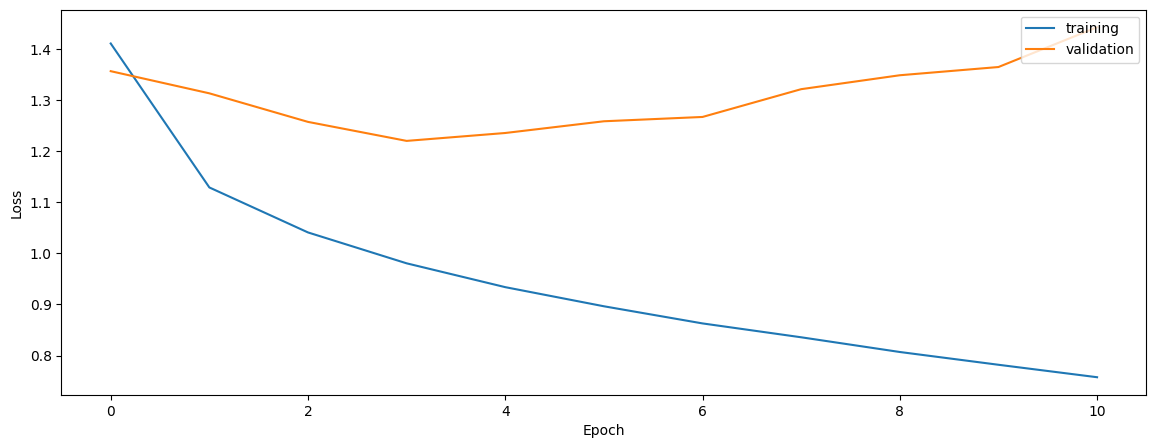

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6362271511139154
0.5457420088390976
0.5933107987902508


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5862996262795862
0.5182221724858251
0.5416192741184986


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6077641258357058
0.5532336064546844
0.5709938687457422


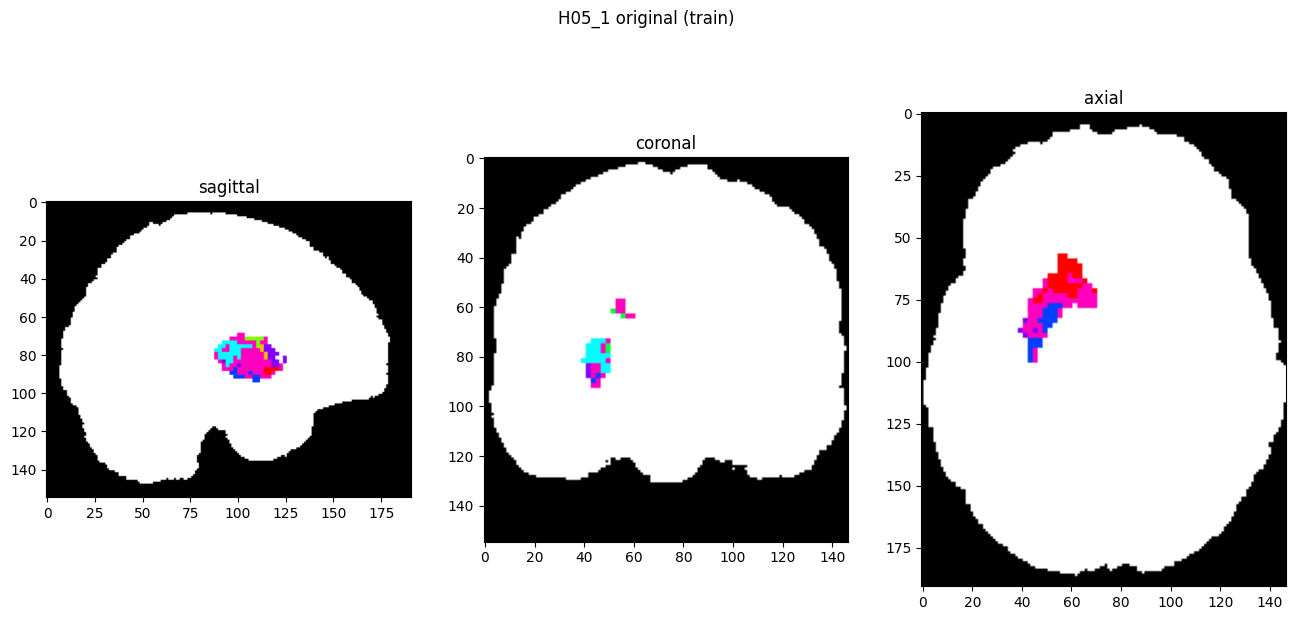

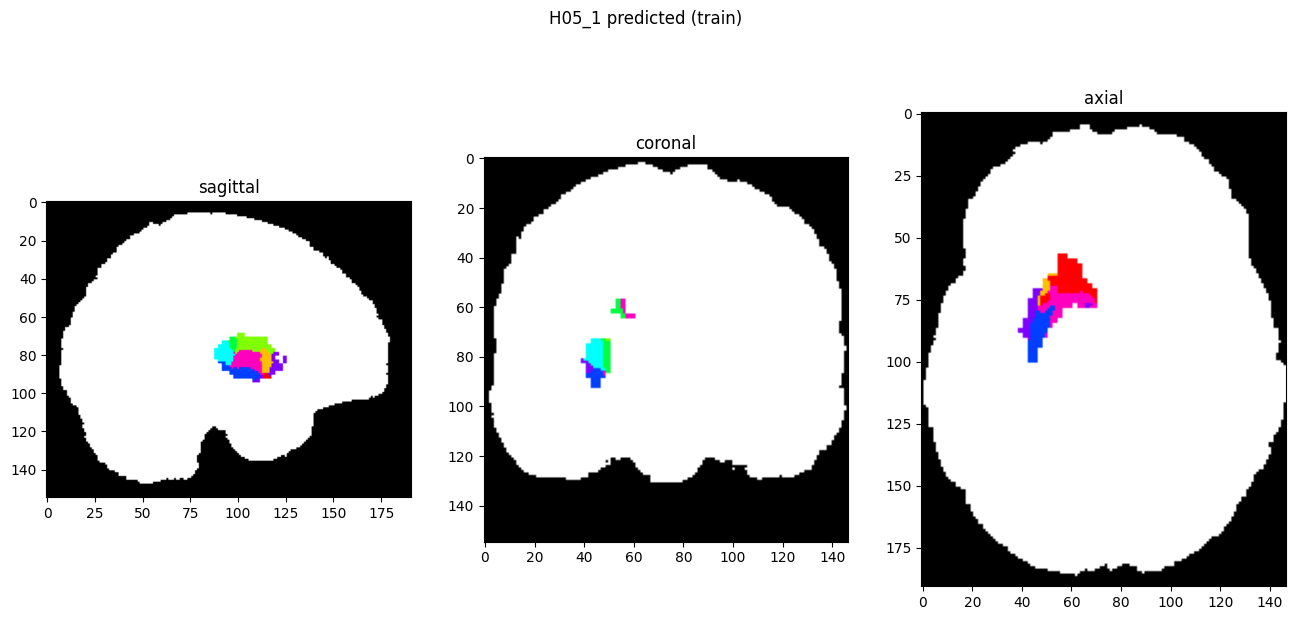

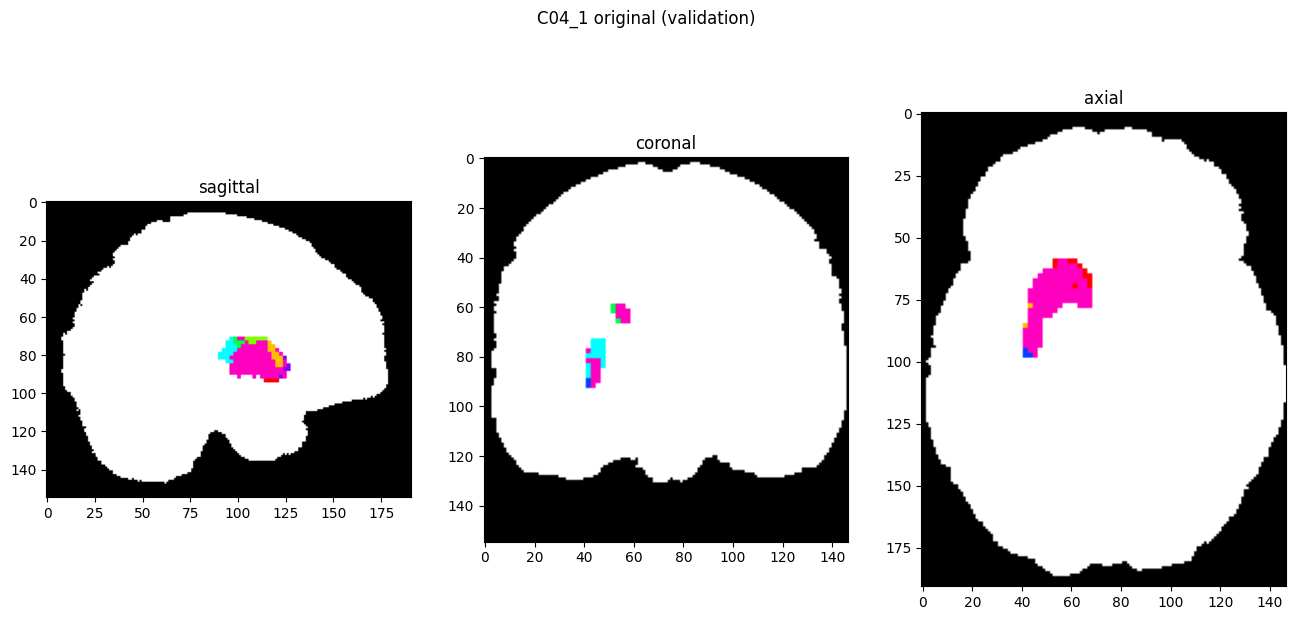

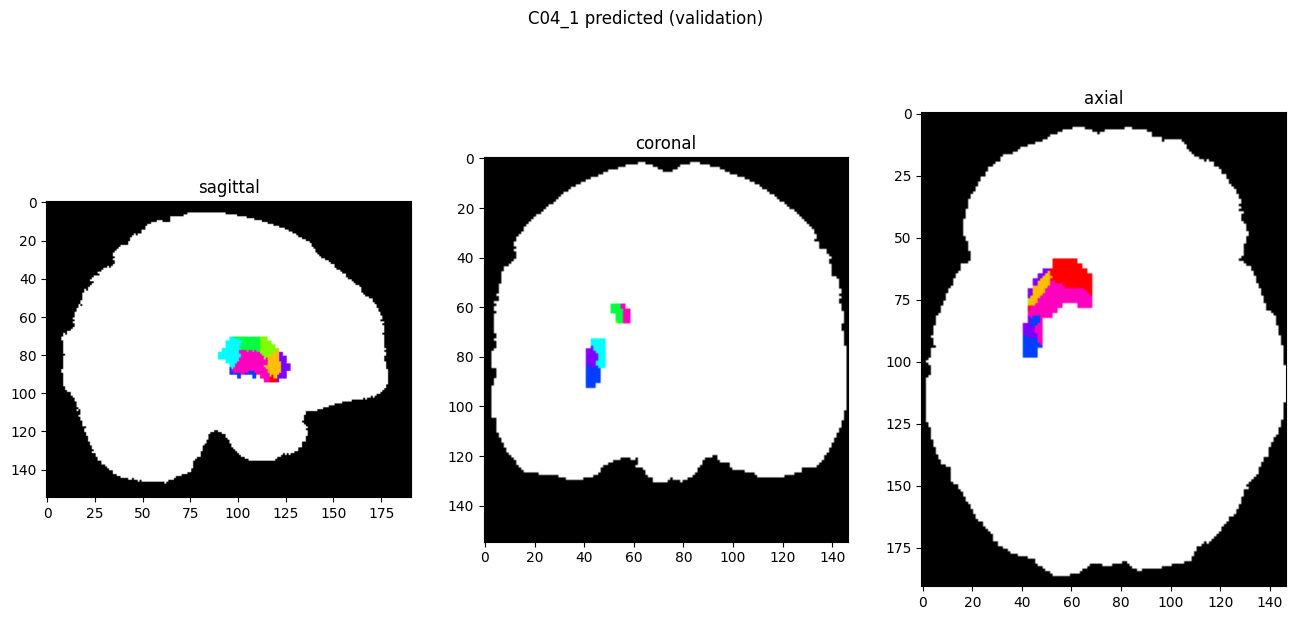

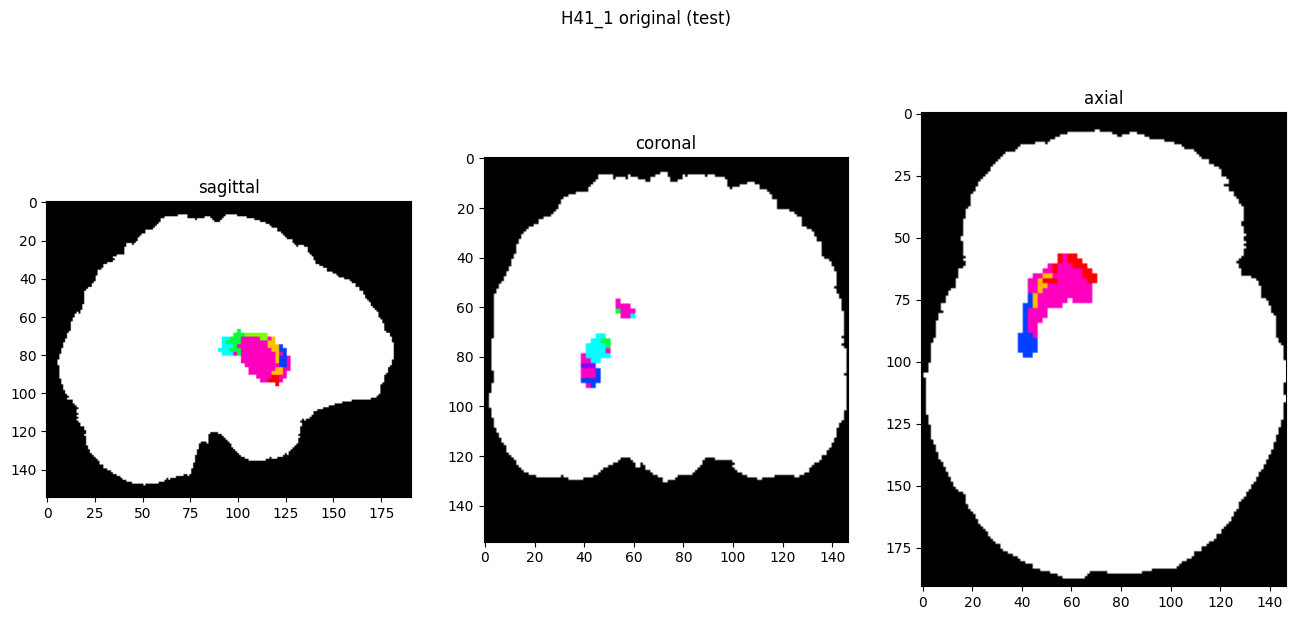

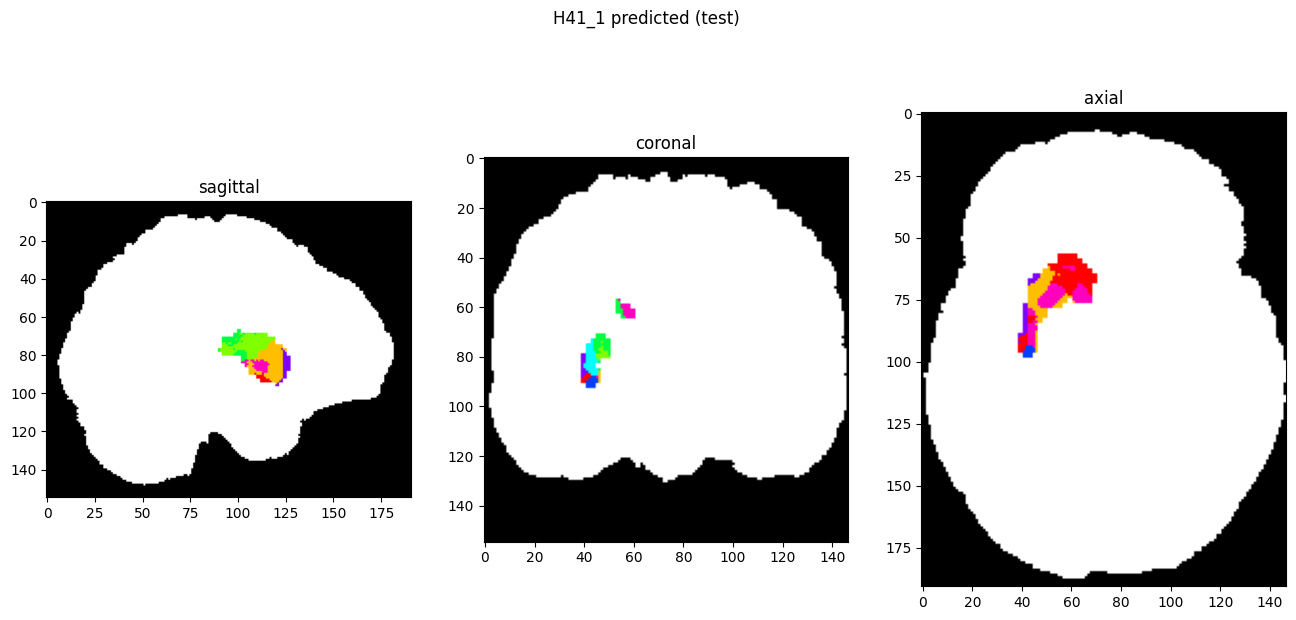

In [10]:
showResults(model, gen, threshold=0)